In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

import math
import itertools

In [2]:
train = pd.read_csv(r"Train.csv")
data_description=pd.read_csv(r"DataDictionary.csv")
test = pd.read_csv(r"Test.csv")

In [3]:
for i in data_description.index:
    print(data_description.loc[i,'Column Name']+": "+data_description.loc[i,'Description']+"\n")

sku_name: Product SKU

starting_inventory: Starting inventory at the beginning of the month that is 
at the dome and unclaimed by a retailer

sellin: The sellin or demand. What is sold in to our customers. 
This is what we are trying to predict 4 months from now (Dependent)

sellin_channel_1: The sellin for channel 1

sellin_channel_2: The sellin for channel 2

sellin_channel_3: The sellin for channel 3

sellin_channel_4: The sellin for channel 4

sellin_channel_5: The sellin for channel 5

sellin_channel_6: The sellin for channel 6

sellin_channel_7: The sellin for channel 7

sellin_channel_8: The sellin for channel 8

sellout: What is sold to the final customer

onhand_inventory: Onhand customer side inventory

sellout_channel_1: The sellout for channel 1

sellout_channel_2: The sellout for channel 2

sellout_channel_3: The sellout for channel 3

sellout_channel_4: The sellout for channel 4

sellout_channel_5: The sellout for channel 5

sellout_channel_6: The sellout for channel 6

s

#### 1) Товары меняют свой lifecycle_stage
#### 2) Есть товары для которых нет информации по 2021
#### 3) Есть товары на 1 строку
#### 4) Товарам менют цены
#### 5) sellout и sellout можеть быть отрицтальным, берем его модуль
#### 6) Товары с малым кол-вом строк обычно не пользуются спросом (малый sellout)

In [4]:
train.loc[:,'sellout'] = abs(train.loc[:,'sellout'])
train.loc[:,'sellin'] = abs(train.loc[:,'sellin'])

In [8]:
columns = ['sku_name','n_rows','stages','n_stages','years','n_years','y_2021','prices','max_sellout','mean_sellout','min_sellout','max_sellin','mean_sellin','min_sellin','prefix']
lst=[]
for sku_name in train.sku_name.unique():
    data_sku = train[train.sku_name == sku_name]
    product_lifecycle_stages = data_sku.product_lifecycle_stage.unique()
    n_rows = data_sku.shape[0]
    years = data_sku.year.unique()
    if 2021 in years:
        _2021 = 1
    else:
        _2021 = 0
    
    prices = data_sku.price.unique()
    
    max_sellout = data_sku.sellout.max()
    mean_sellout = data_sku.sellout.mean()
    min_sellout = data_sku.sellout.min()
    max_sellin = data_sku.sellin.max()
    mean_sellin = data_sku.sellin.mean()
    min_sellin = data_sku.sellin.min()
    prefix = sku_name[:4]
    
    lst.append([sku_name,n_rows, product_lifecycle_stages, len(product_lifecycle_stages ), years, len(years), _2021, prices, max_sellout, mean_sellout, min_sellout, max_sellin, mean_sellin, min_sellin, prefix])
products = pd.DataFrame(columns=columns, data=lst)

In [9]:
products.head()

sku_name  n_rows  stages  n_stages               years  n_years  \
0    YOSHWARDTERR       3     [U]         1        [2016, 2017]        2   
1    YOSHUANEMARX      23     [W]         1        [2018, 2019]        2   
2    YOSHUANEBART      14     [U]         1        [2018, 2019]        2   
3  YOSHTLYNYOSHZZ      10  [K, N]         2              [2021]        1   
4    YOSHTLYNYOSH      15     [U]         1  [2016, 2017, 2018]        3   

   y_2021      prices  max_sellout  mean_sellout  min_sellout  max_sellin  \
0       0        [95]         1013    675.333333            0        2026   
1       0  [155, 159]        96235  42810.260870         3039      439642   
2       0       [125]        52676  14471.428571            0      178288   
3       1       [149]        60780  32213.400000            0      497383   
4       0       [245]       361641  79284.133333            0      221847   

     mean_sellin  min_sellin prefix  
0    1350.666667        1013   YOSH  
1   75402.434783        2026   YOSH  
2   18957.571429        1013   YOSH  
3  249299.300000       54702   YOSH  
4   46665.533333        1013   YOSH

In [10]:
columns = ['sku_name','n_rows','stages','n_stages','years','n_years','y_21','prices','max_sellout','mean_sellout','min_sellout','max_sellin','mean_sellin','min_sellin','prefix']
lst=[]
for sku_name in test.sku_name.unique():
    data_sku = train[train.sku_name == sku_name]
    product_lifecycle_stages = data_sku.product_lifecycle_stage.unique()
    n_rows = data_sku.shape[0]
    years = data_sku.year.unique()
    prices = data_sku.price.unique()
    if 2021 in years:
        _2021 = 1
    else:
        _2021 = 0
    max_sellout = data_sku.sellout.max()
    mean_sellout = data_sku.sellout.mean()
    min_sellout = data_sku.sellout.min()
    max_sellin = data_sku.sellin.max()
    mean_sellin = data_sku.sellin.mean()
    min_sellin = data_sku.sellin.min()
    prefix = sku_name[:4]
    
    lst.append([sku_name,n_rows, product_lifecycle_stages, len(product_lifecycle_stages ), years, len(years),_2021, prices, max_sellout, mean_sellout, min_sellout, max_sellin, mean_sellin, min_sellin, prefix])
test_products = pd.DataFrame(columns=columns, data=lst)

In [11]:
test_products.head()

sku_name  n_rows        stages  n_stages         years  n_years  \
0  YOSHTLYNYOSHZZ      10        [K, N]         2        [2021]        1   
1    YOSHRENECARL      16  [T, M, L, N]         4  [2019, 2021]        2   
2    YOSHLEENBART      16  [T, M, L, N]         4  [2019, 2021]        2   
3  YOSHILSEHOWAZZ       2        [K, T]         2        [2021]        1   
4  WHITSHIAALBEZZ      10           [W]         1        [2021]        1   

   y_21      prices  max_sellout  mean_sellout  min_sellout  max_sellin  \
0     1       [149]      60780.0    32213.4000          0.0    497383.0   
1     1  [125, 129]     147898.0    89840.4375      16208.0    961337.0   
2     1  [125, 129]     231977.0    69327.1875      26338.0    766841.0   
3     1       [149]       6078.0     3039.0000          0.0      8104.0   
4     1       [169]     255276.0    80330.9000       8104.0    249198.0   

   mean_sellin  min_sellin prefix  
0  249299.3000     54702.0   YOSH  
1  264582.9375     52676.0   YOSH  
2  326375.9375     42546.0   YOSH  
3    7091.0000      6078.0   YOSH  
4  100894.8000     46598.0   WHIT

#### У товаров в артикулах есть 4(?) буквенные приставки

In [12]:
prefix = {}
prefix_sku_names = {}
for sku_name in products.sku_name.unique():
    try:
        prefix[sku_name[:4]]+=1
        prefix_sku_names[sku_name[:4]].append(sku_name)
    except:
        prefix[sku_name[:4]]=1
        prefix_sku_names[sku_name[:4]] = [sku_name]

In [13]:
train['prefix'] = train['sku_name'].apply(lambda x: x[0:4])

### sellin не всегда равно (sellin_channel_1 + ... + sellin_channel_8) (всегда >=)

In [14]:
train[train.sellin > (train.sellin_channel_1 + train.sellin_channel_2 + train.sellin_channel_3 + train.sellin_channel_4 + train.sellin_channel_5 + train.sellin_channel_6 + train.sellin_channel_7 + train.sellin_channel_8)]

sku_name  starting_inventory  sellin  sellin_channel_1  \
3      YOSHUANEMARX                   0  320108              4052   
4      YOSHUANEMARX                   0  132703              2026   
5      YOSHUANEMARX                   0  168158                 0   
6      YOSHUANEMARX                   0   43559                 0   
7      YOSHUANEMARX                   0   22286                 0   
...             ...                 ...     ...               ...   
44899   ABEAHAMASHL              565254   42546             15195   
44900   ABEAHAMASHL              578423    7091              1013   
44901   ABEAHAMASHL              560189   24312              7091   
44902   ABEAHAMASHL              432551  156002            101300   
44903   ABEAHAMASHL              406213   34442              6078   

       sellin_channel_2  sellin_channel_3  sellin_channel_4  sellin_channel_5  \
3                 40520            240081              4052              6078   
4                     0             81040              3039             25325   
5                     0            151950              6078                 0   
6                  6078             34442                 0                 0   
7                     0             17221              4052                 0   
...                 ...               ...               ...               ...   
44899             20260                 0                 0                 0   
44900                 0                 0                 0                 0   
44901                 0                 0                 0                 0   
44902             10130                 0                 0                 0   
44903                 0                 0                 0                 0   

       sellin_channel_6  sellin_channel_7  ...  year  product_lifecycle_stage  \
3                 18234                 0  ...  2018                        W   
4                 18234                 0  ...  2018                        W   
5                  8104                 0  ...  2018                        W   
6                     0                 0  ...  2018                        W   
7                     0                 0  ...  2018                        W   
...                 ...               ...  ...   ...                      ...   
44899              5065                 0  ...  2021                        W   
44900              5065                 0  ...  2021                        W   
44901              1013                 0  ...  2021                        W   
44902              1013                 0  ...  2021                        W   
44903              4052                 0  ...  2021                        W   

        FLAG100  disc_month  cum_disc  CAT_GENDER_BOTH  CAT_GENDER_MEN  \
3      0.270966           1         1                0               0   
4      0.063004           0         1                0               0   
5      0.000000           0         1                0               0   
6      0.000000           0         0                0               0   
7      0.000000           0         0                0               0   
...         ...         ...       ...              ...             ...   
44899  0.000000           0         1                0               0   
44900  0.500000           0         0                0               0   
44901  0.000000           0         0                0               0   
44902  0.000000           0         0                0               0   
44903  0.333333           0         0                0               0   

       CAT_GENDER_WOMEN  Weeks  prefix  
3                     1      1    YOSH  
4                     1      0    YOSH  
5                     1      0    YOSH  
6                     1      1    YOSH  
7                     1      0    YOSH  
...                 ...    ...     ...  
44899                 1      0    ABEA  
44900              

### 10 month 2019 у каждого товара разбит на несколько строк, строки очень непонятные, не знаю что с ними делать (удалю все кроме одного)

In [15]:
#bads = pd.read_csv(r"bad_rows.csv")

In [16]:
#bads

In [17]:
#bads.to_csv('bad_rows.csv',index=False)

In [18]:
for sku_name in tqdm(train.sku_name.unique()):
    temp = train[(train.sku_name==sku_name) & (train.year==2019) & (train.month==10)]
    rows = temp.shape[0]
    indexes = temp.index
    if rows == 2:
        train.drop(indexes[0], inplace=True)
    elif rows == 4:
        train.drop(indexes[1:], inplace = True)

        

  0%|          | 0/3868 [00:00<?, ?it/s]

### boxplot
#### цены по товарам схожие, так как квартили и медиана примерно на одном уровне

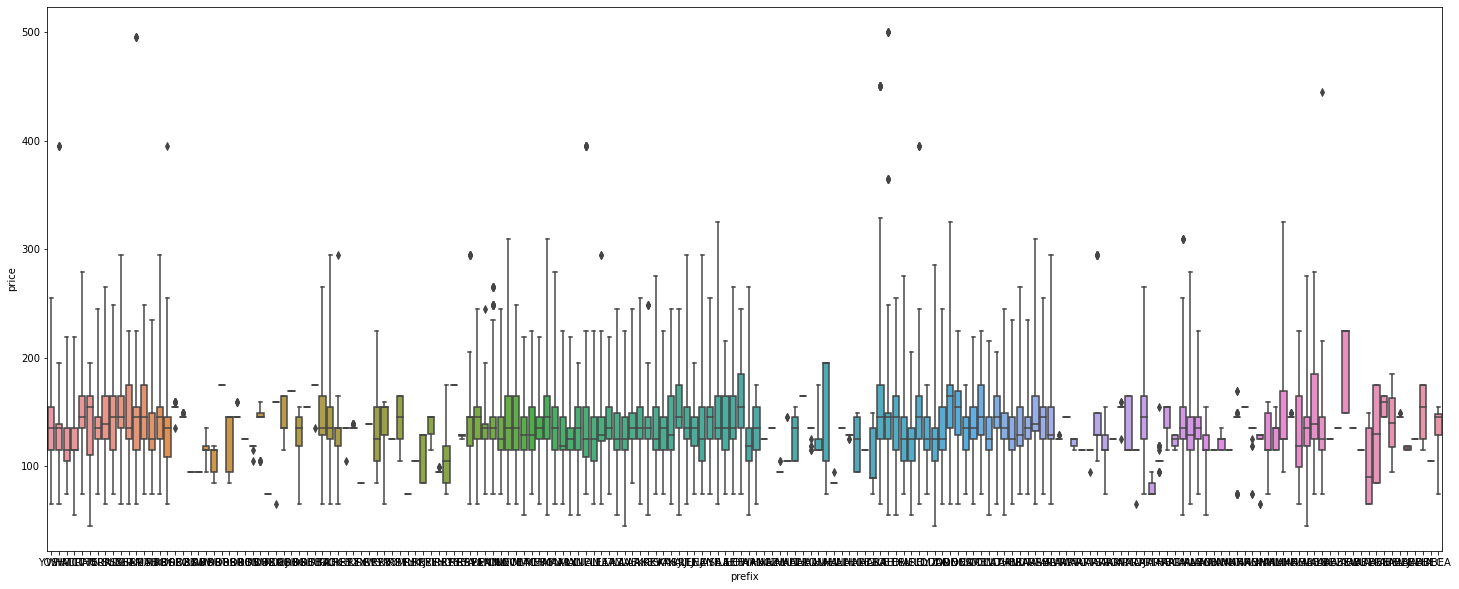

In [19]:
plt.figure(figsize=(25,10))
sns.boxplot(x="prefix", y="price", data=train, whis=5)
plt.show()

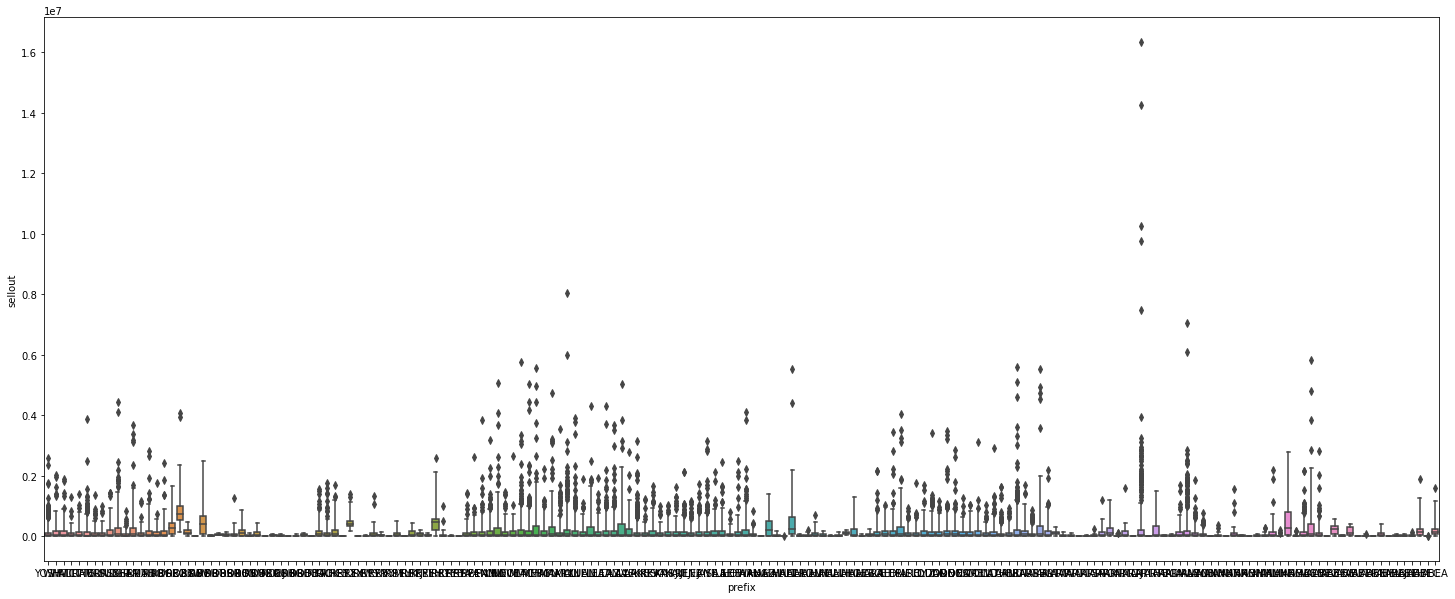

In [20]:
plt.figure(figsize=(25,10))
sns.boxplot(x="prefix", y="sellout", data=train, whis=5)
plt.show()

### Plot
#### Смотря на товары, для которых дано большое количество месяцев, видна 12 месячная переодичность и тенденция к спаду
#### Синия линия = сумма товаров закупленная в этом месяце
#### Зеленая линия = сумма товаров проданная в данном месяце

In [21]:
print(prefix)

{'YOSH': 43, 'WHIT': 36, 'WALL': 33, 'VICT': 24, 'TRAN': 43, 'THOR': 34, 'TERR': 30, 'SUND': 38, 'SUDI': 34, 'SIGR': 38, 'SHER': 33, 'SAMA': 35, 'RUTH': 34, 'RUDO': 37, 'RUBY': 37, 'ROSE': 41, 'ROBZ': 2, 'ROBX': 1, 'ROBW': 1, 'ROBV': 1, 'ROBU': 3, 'ROBT': 3, 'ROBS': 1, 'ROBR': 4, 'ROBO': 2, 'ROBN': 1, 'ROBM': 2, 'ROBL': 3, 'ROBK': 1, 'ROBJ': 2, 'ROBH': 4, 'ROBG': 1, 'ROBE': 6, 'ROBB': 1, 'ROBA': 2, 'RIGO': 35, 'RICK': 44, 'RHEB': 29, 'REYZ': 2, 'REYX': 1, 'REYW': 1, 'REYS': 1, 'REYR': 11, 'REYO': 4, 'REYM': 1, 'REYL': 7, 'REYK': 1, 'REYJ': 1, 'REYI': 3, 'REYH': 2, 'REYG': 1, 'REYE': 8, 'REYB': 1, 'REYA': 1, 'REVA': 39, 'REEN': 42, 'PENN': 45, 'PAMU': 38, 'ONEI': 41, 'NOVE': 47, 'NOLA': 33, 'MITC': 44, 'MICH': 76, 'MERC': 49, 'MAYN': 34, 'MAXI': 42, 'MARX': 52, 'MALI': 33, 'LYNE': 46, 'LUAN': 30, 'LILL': 38, 'LEAT': 48, 'LEAN': 31, 'LAZA': 46, 'LAVE': 37, 'LARI': 30, 'LAKE': 81, 'KRIS': 44, 'KEVA': 33, 'KATH': 40, 'KARR': 47, 'KAIT': 45, 'JULI': 71, 'JENE': 44, 'JEAN': 48, 'JAYE': 38, '

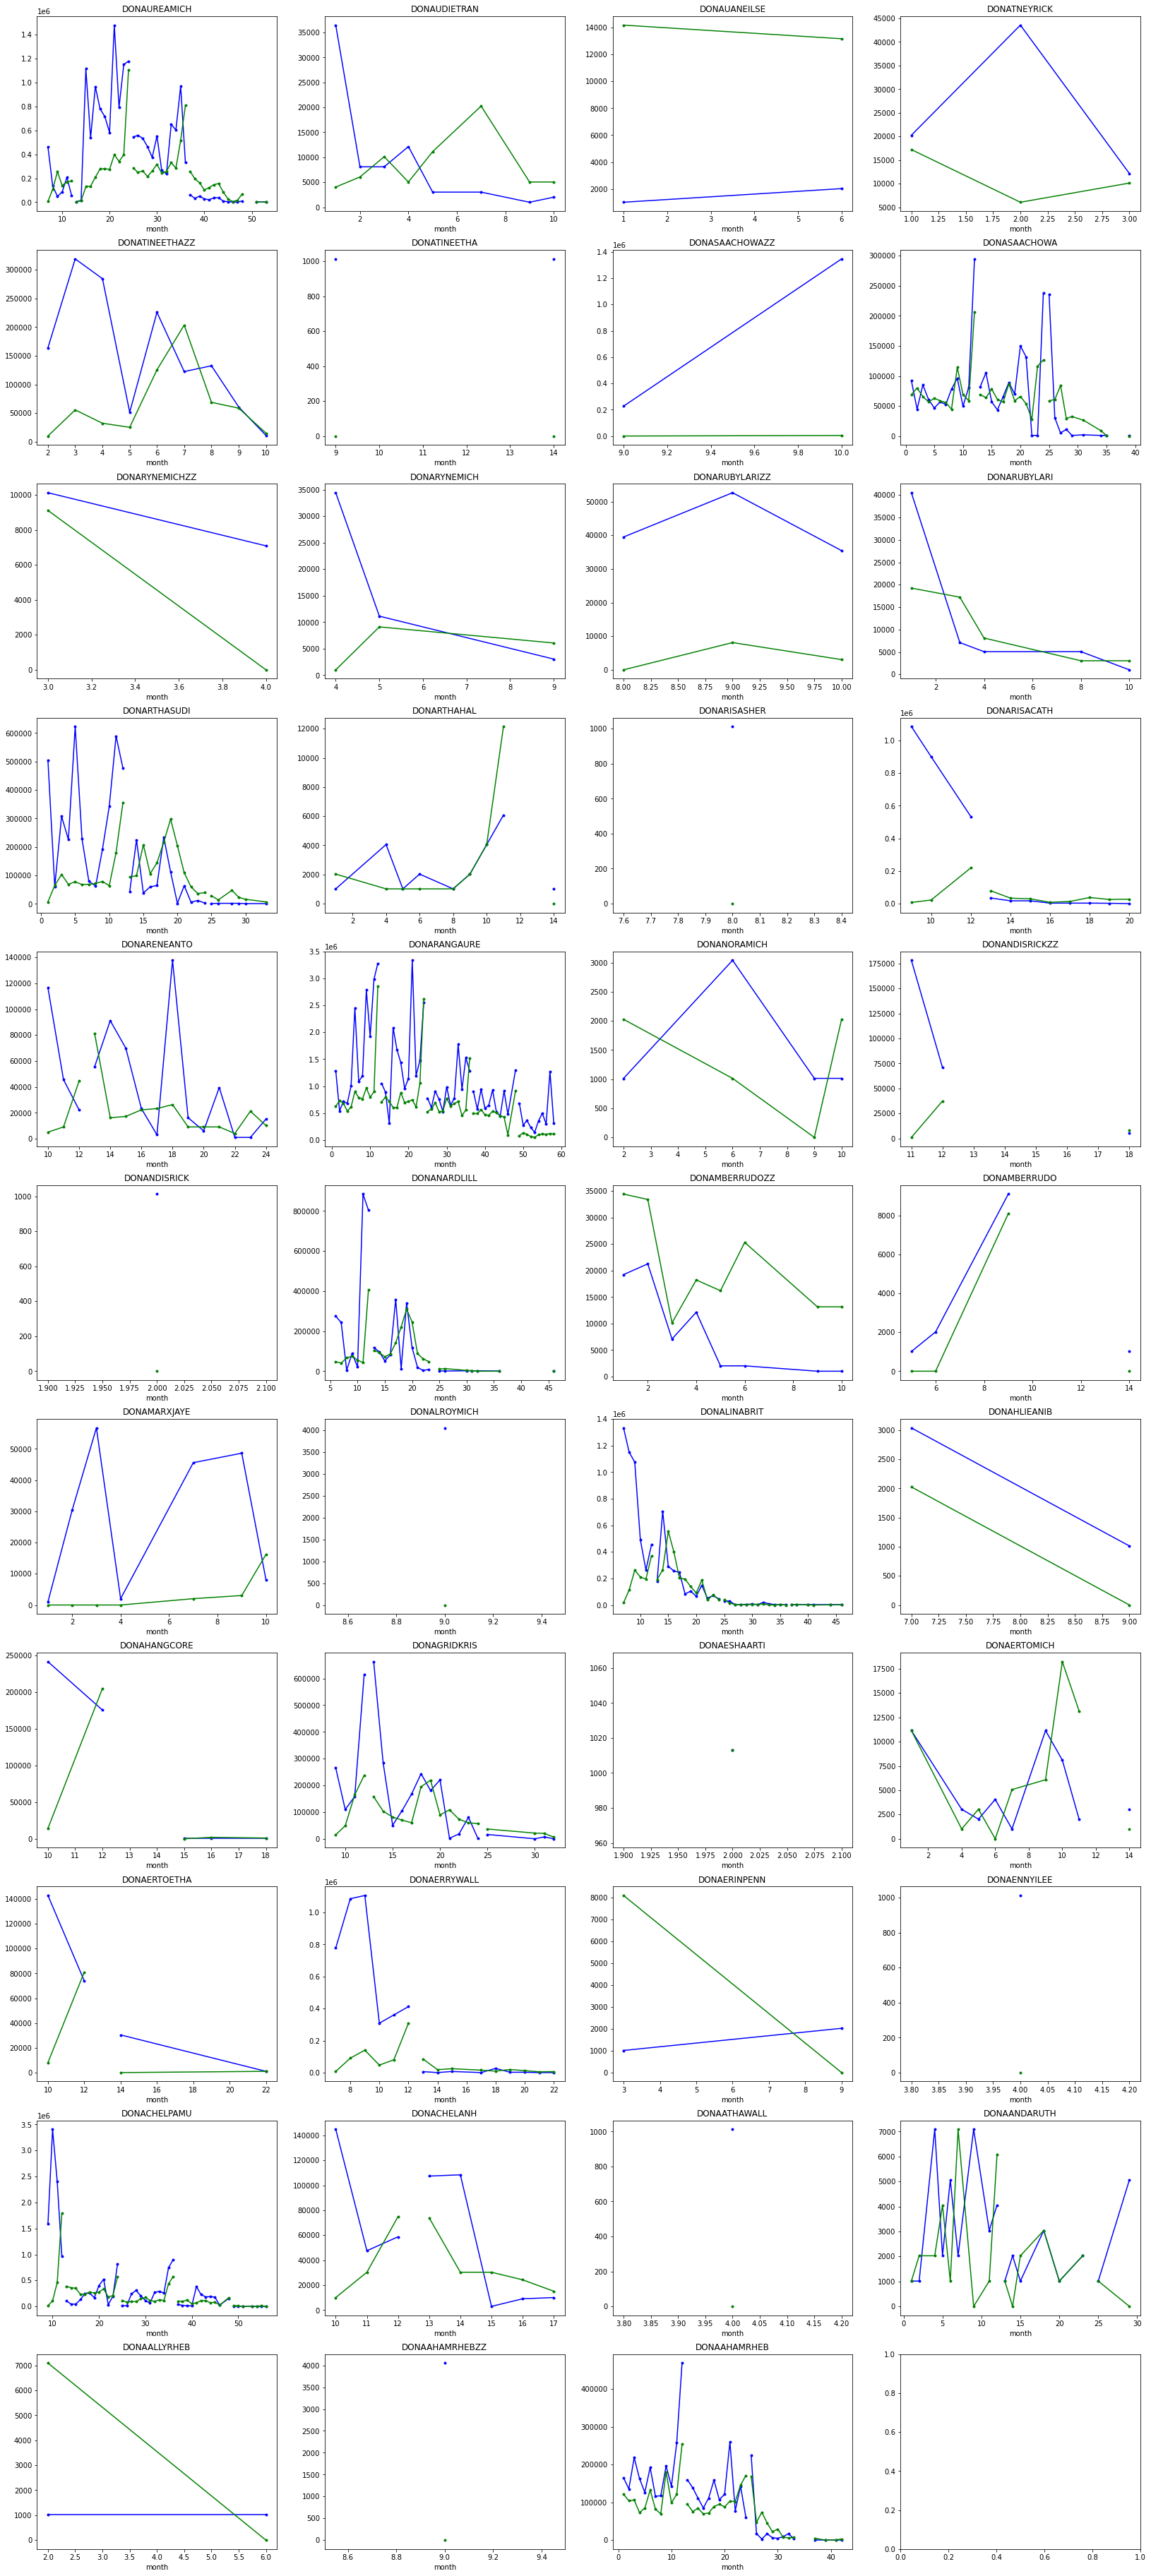

In [22]:
pref = 'DONA'
n_plots = len(prefix_sku_names[pref])
cols = 4
rows = math.ceil(n_plots/cols)
fig, ax = plt.subplots(rows,cols,squeeze=False, figsize=(7*cols,4*1.5*rows))

coordinates = list(itertools.product(range(rows),range(cols)))
for coor, sku_name in zip(coordinates, prefix_sku_names[pref]):
    axes = ax[coor[0]][coor[1]]
    temp = train[train.sku_name==sku_name]
    k=0
    for year in temp.year.unique():
        axes.plot(temp[temp.year == year].month.unique() + 12*k, temp[temp.year == year].sellin, marker = '.', color = 'blue')
        axes.plot(temp[temp.year == year].month.unique() + 12*k, temp[temp.year == year].sellout, marker = '.', color = 'green')
        k+=1
    axes.set_title(sku_name)
    axes.set_xlabel('month')
plt.show()

#### Среднее кол-во sellout у товаров с разным количество данных

In [23]:
bars = []
x = products.n_rows.unique()
x.sort()
for i in x:
    bars.append(products[products.n_rows == i].mean_sellout.mean())

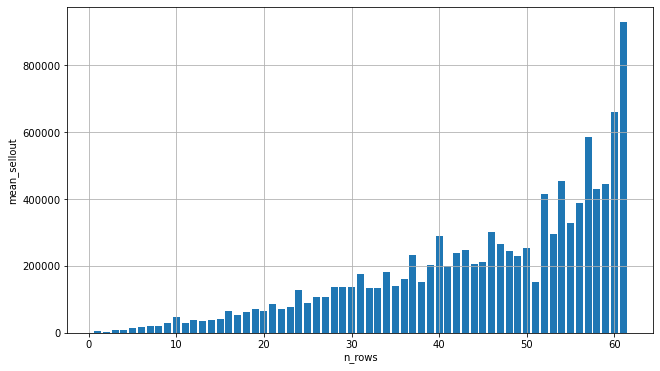

In [24]:
plt.figure(figsize=(7*1.5, 4*1.5))
plt.grid(True)
plt.bar(x=x, height=bars)
plt.xlabel('n_rows')
plt.ylabel('mean_sellout')
plt.show()

In [71]:
products[(products.n_rows>0) & (products.n_rows<2)]

sku_name  n_rows stages  n_stages   years  n_years  y_2021 prices  \
9     YOSHRICKLAZA       1    [U]         1  [2016]        1       0   [95]   
11    YOSHOVANTERR       1    [U]         1  [2016]        1       0  [115]   
17    YOSHLONAVICT       1    [U]         1  [2016]        1       0   [85]   
18    YOSHLONALILL       1    [U]         1  [2016]        1       0  [115]   
21    YOSHLIAMROSE       1    [U]         1  [2016]        1       0  [115]   
...            ...     ...    ...       ...     ...      ...     ...    ...   
3840   ABETLEYERIC       1    [U]         1  [2016]        1       0  [115]   
3843    ABEROBKRIS       1    [U]         1  [2016]        1       0  [115]   
3850   ABELROYDONA       1    [U]         1  [2017]        1       0  [185]   
3851   ABELIANHARL       1    [U]         1  [2016]        1       0   [95]   
3864   ABEANNAONEI       1    [U]         1  [2016]        1       0   [75]   

      max_sellout  mean_sellout  min_sellout  max_sellin  mean_sellin  \
9               0           0.0            0        2026       2026.0   
11              0           0.0            0        1013       1013.0   
17              0           0.0            0        1013       1013.0   
18              0           0.0            0        3039       3039.0   
21              0           0.0            0        1013       1013.0   
...           ...           ...          ...         ...          ...   
3840         1013        1013.0         1013        1013       1013.0   
3843         2026        2026.0         2026        4052       4052.0   
3850         1013        1013.0         1013        1013       1013.0   
3851         2026        2026.0         2026        1013       1013.0   
3864         1013        1013.0         1013        1013       1013.0   

      min_sellin prefix  
9           2026   YOSH  
11          1013   YOSH  
17          1013   YOSH  
18          3039   YOSH  
21          1013   YOSH  
...          ...    ...  
3840        1013   ABET  
3843        4052   ABER  
3850        1013   ABEL  
3851        1013   ABEL  
3864        1013   ABEA  

[592 rows x 15 columns]

In [106]:
train = train.drop(columns=['sellin_channel_1','sellin_channel_2','sellin_channel_2','sellin_channel_3','sellin_channel_4','sellin_channel_5','sellin_channel_6','sellin_channel_7',
                              'sellin_channel_8','sellout_channel_1','sellout_channel_2','sellout_channel_3','sellout_channel_4','sellout_channel_5','sellout_channel_6','sellout_channel_7',
                              'sellout_channel_8','sellout_channel_9','sellout_channel_10','onhand_inventory_channel_1','onhand_inventory_channel_2','onhand_inventory_channel_3',
                              'onhand_inventory_channel_4','onhand_inventory_channel_5','onhand_inventory_channel_6','onhand_inventory_channel_7','onhand_inventory_channel_8',
                              'onhand_inventory_channel_9','onhand_inventory_channel_10'])

In [107]:
def n_month(row):
    start_year = 2016
    return (row.year-start_year)*12 + row.month

train['nth_month'] = train.apply(n_month,axis=1)

In [108]:
train

sku_name  starting_inventory  sellin  sellout  onhand_inventory  \
0      YOSHWARDTERR                   0    1013     1013                 0   
1      YOSHWARDTERR                   0    2026        0              1013   
2      YOSHWARDTERR                   0    1013     1013                 0   
3      YOSHUANEMARX                   0  320108    56728            259328   
4      YOSHUANEMARX                   0  132703    90157            270471   
...             ...                 ...     ...      ...               ...   
44902   ABEAHAMASHL              432551  156002    25325            291744   
44903   ABEAHAMASHL              406213   34442    38494            396083   
44904   ABEAHAMASHL              375823   38494    56728            274523   
44905   ABEAHAMASHL              400135   29377    65845            123586   
44906   ABEAHAMASHL              410265   18234    29377            100287   

       leftover_inventory  price  month  year product_lifecycle_stage  \
0                       0     95      7  2016                       U   
1                    2026     95      2  2017                       U   
2                       0     95      5  2017                       U   
3                  263380    155      4  2018                       W   
4                   42546    155      5  2018                       W   
...                   ...    ...    ...   ...                     ...   
44902              130677    149      6  2021                       W   
44903               -4052    149      7  2021                       W   
44904              -18234    149      8  2021                       W   
44905              -36468    149      9  2021                       W   
44906              -11143    149     10  2021                       W   

        FLAG100  disc_month  cum_disc  CAT_GENDER_BOTH  CAT_GENDER_MEN  \
0      0.000000           0         0                0               1   
1      0.000000           0         0                0               1   
2      0.000000           0         0                0               1   
3      0.270966           1         1                0               0   
4      0.063004           0         1                0               0   
...         ...         ...       ...              ...             ...   
44902  0.000000           0         0                0               0   
44903  0.333333           0         0                0               0   
44904  0.400000           1         1                0               0   
44905  0.000000           0         1                0               0   
44906  0.452381           1         1                0               0   

       CAT_GENDER_WOMEN  Weeks prefix         ds  nth_month  
0                     0      1   YOSH 2016-07-01          7  
1                     0      0   YOSH 2017-02-01         14  
2                     0      0   YOSH 2017-05-01         17  
3                     1      1   YOSH 2018-04-01         28  
4                     1      0   YOSH 2018-05-01         29  
...                 ...    ...    ...        ...        ...  
44902                 1      0   ABEA 2021-06-01         66  
44903                 1      0   ABEA 2021-07-01         67  
44904                 1      1   ABEA 2021-08-01         68  
44905                 1      0   ABEA 2021-09-01         69  
44906                 1      1   ABEA 2021-10-01         70  

[43234 rows x 20 columns]

In [77]:
new_train.to_csv('New_train.csv', index=False)

#### ЧТО ТАМ С ТЕСТОВЫМ ДАТАСЕТОМ

In [30]:
test_sku = set(test.sku_name.unique())
train_sku = set(train.sku_name.unique())

In [31]:
test_sku-train_sku

{'CATHHALREYZZ'}

In [32]:
len(test_sku - train_sku), len(test_sku & train_sku), len(train_sku - test_sku) 

(1, 381, 3487)

In [33]:
bars = [0]*60
for sku_name in test_sku:
    try:
        bars[products[products.sku_name == sku_name].n_rows.item()]+=1
    except:
        bars[0]+=1

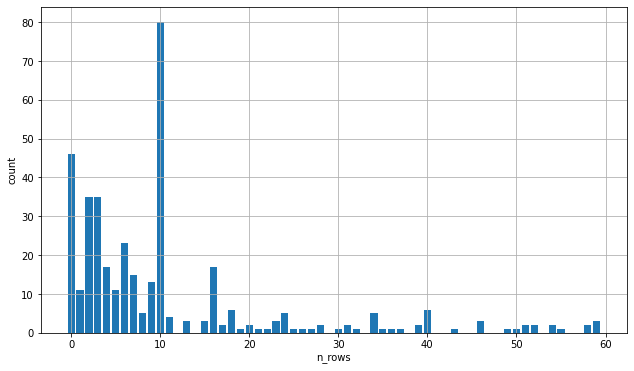

In [34]:
plt.figure(figsize=(7*1.5, 4*1.5))
plt.grid(True)
plt.bar(x=  np.arange(len(bars)),height=bars)
plt.xlabel('n_rows')
plt.ylabel('сount')
plt.show()

In [35]:
products[products.n_rows==18]

sku_name  n_rows     stages  n_stages  \
111   WALLANDALEAN      18     [N, L]         2   
282   SUDIUANEARLE      18  [N, M, L]         3   
447   RUTHEIDAMICH      18     [X, W]         2   
470   RUDONARDKRIS      18        [U]         1   
488   RUDOATHARUTH      18     [U, K]         2   
508   RUBYLEENISAA      18     [N, W]         2   
706   RHEBILDASHER      18        [U]         1   
745    REYLANDWALL      18        [U]         1   
792   REVAGRIDRIGO      18  [N, M, L]         3   
886   PENNANNABART      18     [W, U]         2   
921   PAMUELLYLAVE      18        [U]         1   
983   NOVERRONALBE      18        [N]         1   
1017  NOLAZAROBRIT      18        [U]         1   
1059  MITCRENEHANG      18        [W]         1   
1101  MICHTLYNMICH      18        [U]         1   
1190  MERCLENEGRAH      18        [U]         1   
1211  MERCBARTRHEB      18        [U]         1   
1231  MAYNMBERRUBY      18        [U]         1   
1272  MAXILEENMAXI      18        [W]         1   
1300  MARXRTIERUDO      18        [N]         1   
1349  MALITINETERR      18        [U]         1   
1369  MALIESHAONEI      18        [U]         1   
1411  LYNEHEBAMAYN      18        [U]         1   
1424  LYNEALLYSIGR      18        [U]         1   
1432  LUANRUBYSAMA      18        [W]         1   
1570  LEANANNAARLE      18        [U]         1   
1712  LAKEOLPHRIGO      18        [W]         1   
1713   LAKENORAANH      18        [W]         1   
1765  LAKEALLYLARI      18        [U]         1   
1788  KRISNALDYOSH      18     [W, K]         2   
1827  KEVALIZAARTI      18        [W]         1   
1835  KEVAGRIDLAKE      18     [N, W]         2   
1851  KATHRTHAONEI      18        [U]         1   
1861  KATHNALDAURE      18        [W]         1   
1893  KARRTINEGILD      18     [O, W]         2   
1975   KAITABELYNE      18        [U]         1   
2026  JULIIBALJAYE      18        [U]         1   
2028  JULIHLIEARMA      18        [U]         1   
2032  JULIETTAJEAN      18        [W]         1   
2058  JENERISAHOWA      18        [U]         1   
2127   JEANERTOHAL      18        [U]         1   
2176   JAYEABEYOSH      18        [W]         1   
2185  ISAAOVANROSE      18        [U]         1   
2206  ISAAHAELLAVE      18        [U]         1   
2315  HOWARRONGILD      18        [U]         1   
2330  HOWAILSECATH      18        [U]         1   
2449   HALERTOARLE      18        [W]         1   
2488  GRAHLIANLAZA      18        [U]         1   
2505   GILDUANEHAL      18  [T, N, W]         3   
2509  GILDOLPHKAIT      18  [T, N, L]         3   
2728  ELIZSHIACARL      18        [W]         1   
2731   ELIZROBELIZ      18        [U]         1   
2901  DONAERRYWALL      18     [O, W]         2   
2929  DESMMARXDESM      18        [W]         1   
3168  CANDATHAKRIS      18        [W]         1   
3231  BRITERINDESM      18  [T, M, L]         3   
3397   ARTVETARIGO      18        [W]         1   
3681   ANHNDISHARL      18        [U]         1   
3839    ABEUREAREY      18        [W]         1   

                               years  n_years  y_2021      prices  \
111                     [2019, 2021]        2       1  [105, 109]   
282                     [2019, 2021]        2       1  [135, 139]   
447               [2018, 2019, 2021]        3       1  [125, 129]   
470               [2016, 2017, 2018]        3       0       [105]   
488   [2016, 2017, 2018, 2019, 2021]        5       1       [165]   
508                     [2019, 2021]        2       1  [105, 109]   
706         [2016, 2017, 2018, 2019]        4       0       [165]   
745               [2016, 2017, 2018]        3       0       [125]   
792                     [2019, 2021]        2       1  [105, 109]   
886               [2017, 2018, 2019]        3       0        [75]   
921               [2017, 2018, 2019]        3       0       [105]   
983                     [2018, 2019]        2       0       [245]   
1017              [2016, 2017, 2018]        3       

# Sellin

#### Среднее кол-во sellin у товаров с разным количество данных

In [36]:
y = []
x = test_products.n_rows.unique()
x.sort()
for i in x:
    y.append(test_products[test_products.n_rows == i].mean_sellin.mean())

In [37]:
x

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 34, 35, 36, 37,
       39, 40, 43, 46, 49, 50, 51, 52, 54, 55, 58, 59, 60, 61],
      dtype=int64)

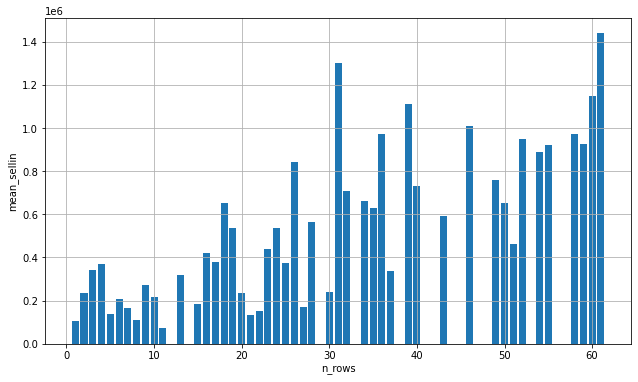

In [38]:
plt.figure(figsize=(7*1.5, 4*1.5))
plt.grid(True)
plt.bar(x=x, height=y)
plt.xlabel('n_rows')
plt.ylabel('mean_sellin')
plt.show()

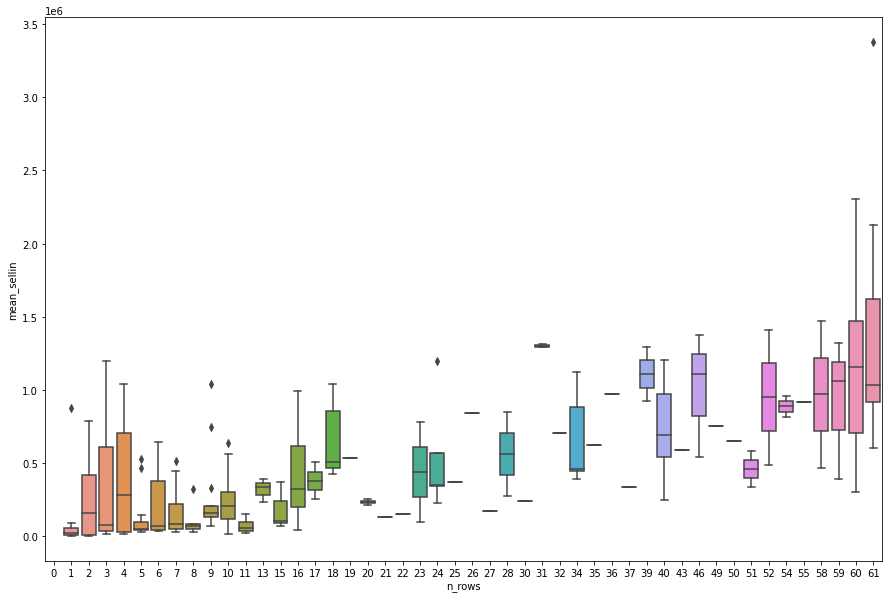

In [39]:
plt.figure(figsize=(15,10))
ax = sns.boxplot(x="n_rows", y="mean_sellin", data=test_products)
plt.show(ax)

### Распределение максимумов у товаров, по месяцам (Провека на holidays пики)

In [40]:
values = {1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,
         9:0,10:0,11:0,12:0}
for sku_name in test.sku_name.unique():
    temp = train[train.sku_name == sku_name]
    if temp.shape[0]>12:
        for year in temp.year.unique():
            temp_values = temp[temp.year == year].sort_values(by='sellin', ascending = False).head(1).month.value_counts()
            for value in temp_values.index:
                values[value]+=temp_values[value]

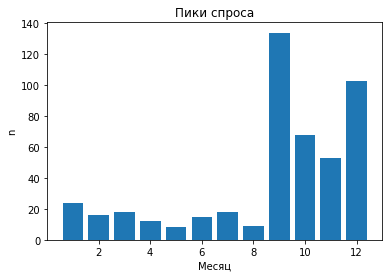

In [41]:
plt.title('Пики спроса')
plt.bar(x=np.arange(1,13), height = values.values())
plt.xlabel('Месяц')
plt.ylabel('n')
plt.show()

In [42]:
men_sku = test[test.CAT_GENDER_MEN == 1].sku_name.unique()
women_sku = test[test.CAT_GENDER_WOMEN == 1].sku_name.unique()
both_sku = test[test.CAT_GENDER_BOTH == 1].sku_name.unique()
men_peaks = {1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0,11:0,12:0}
women_peaks = {1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0,11:0,12:0}
both_peaks = {1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0,11:0,12:0}
for sku_name in men_sku:
    temp = train[train.sku_name == sku_name]
    if temp.shape[0]>12:
        for year in temp.year.unique():
            peak = temp[temp.year == year].sort_values(by='sellin', ascending = False).head(1).month.item()
            men_peaks[peak]+=1
for sku_name in women_sku:
    temp = train[train.sku_name == sku_name]
    if temp.shape[0]>12:
        for year in temp.year.unique():
            peak = temp[temp.year == year].sort_values(by='sellin', ascending = False).head(1).month.item()
            women_peaks[peak]+=1
for sku_name in both_sku:
    temp = train[train.sku_name == sku_name]
    if temp.shape[0]>12:
        for year in temp.year.unique():
            peak = temp[temp.year == year].sort_values(by='sellin', ascending = False).head(1).month.item()
            both_peaks[peak]+=1

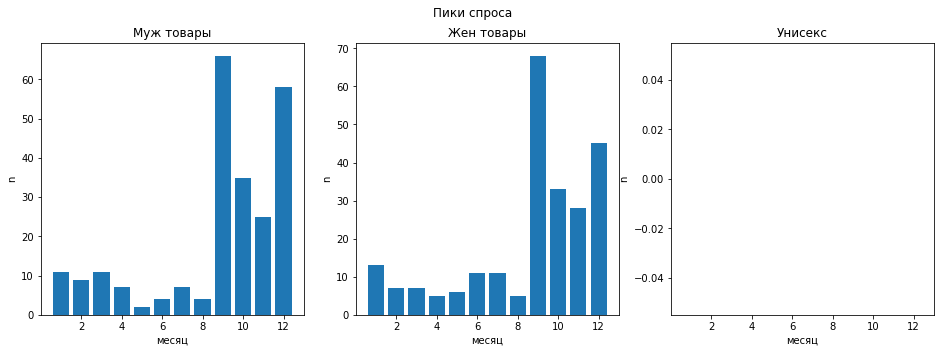

In [43]:
fig, axes = plt.subplots(1,3, figsize=(16,5))
fig.suptitle('Пики спроса')
titles=['Муж товары','Жен товары','Унисекс']
heights = [men_peaks,women_peaks,both_peaks]
for i in range(3):
    axes[i].set_title(titles[i])
    axes[i].bar(x=list(heights[i].keys()), height = heights[i].values())
    axes[i].set_xlabel('месяц')
    axes[i].set_ylabel('n')
    # plt.title('Пики спроса')

Унисекс товаров нет

### Кол во строк у товаров, у которых есть данные на 2021 год

(У всех товаров из тествого набора данных есть данные за 2021 год)

In [44]:
bars = [0]*60
for sku_name in test_products.sku_name:
    try:
        bars[products[(products.sku_name == sku_name) & (products.y_2021 == 1)].n_rows.item()]+=1
    except:
        bars[0]+=1

In [45]:
sum(bars)

382

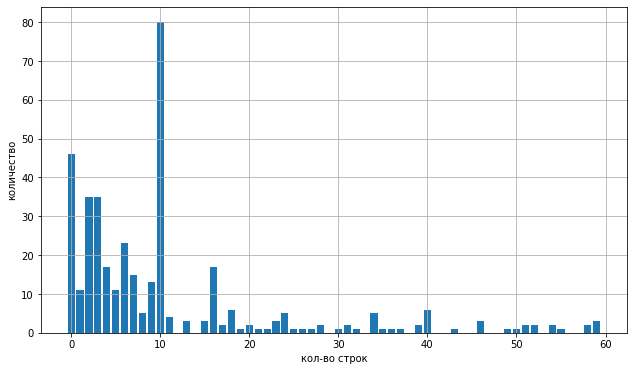

In [46]:
plt.figure(figsize=(7*1.5, 4*1.5))
plt.grid(True)
plt.bar(x=  np.arange(len(bars)),height=bars)
plt.xlabel('кол-во строк')
plt.ylabel('количество')
plt.show()

In [72]:
train.columns

Index(['sku_name', 'starting_inventory', 'sellin', 'sellin_channel_1',
       'sellin_channel_2', 'sellin_channel_3', 'sellin_channel_4',
       'sellin_channel_5', 'sellin_channel_6', 'sellin_channel_7',
       'sellin_channel_8', 'sellout', 'onhand_inventory', 'leftover_inventory',
       'sellout_channel_1', 'sellout_channel_2', 'sellout_channel_3',
       'sellout_channel_4', 'sellout_channel_5', 'sellout_channel_6',
       'sellout_channel_7', 'sellout_channel_8', 'sellout_channel_9',
       'sellout_channel_10', 'onhand_inventory_channel_1',
       'onhand_inventory_channel_2', 'onhand_inventory_channel_3',
       'onhand_inventory_channel_4', 'onhand_inventory_channel_5',
       'onhand_inventory_channel_6', 'onhand_inventory_channel_7',
       'onhand_inventory_channel_8', 'onhand_inventory_channel_9',
       'onhand_inventory_channel_10', 'price', 'month', 'year',
       'product_lifecycle_stage', 'FLAG100', 'disc_month', 'cum_disc',
       'CAT_GENDER_BOTH', 'CAT_GENDER_MEN',

In [73]:
train[['sellin','sellout','onhand_inventory','leftover_inventory']].head()

sellin  sellout  onhand_inventory  leftover_inventory
0    1013     1013                 0                   0
1    2026        0              1013                2026
2    1013     1013                 0                   0
3  320108    56728            259328              263380
4  132703    90157            270471               42546

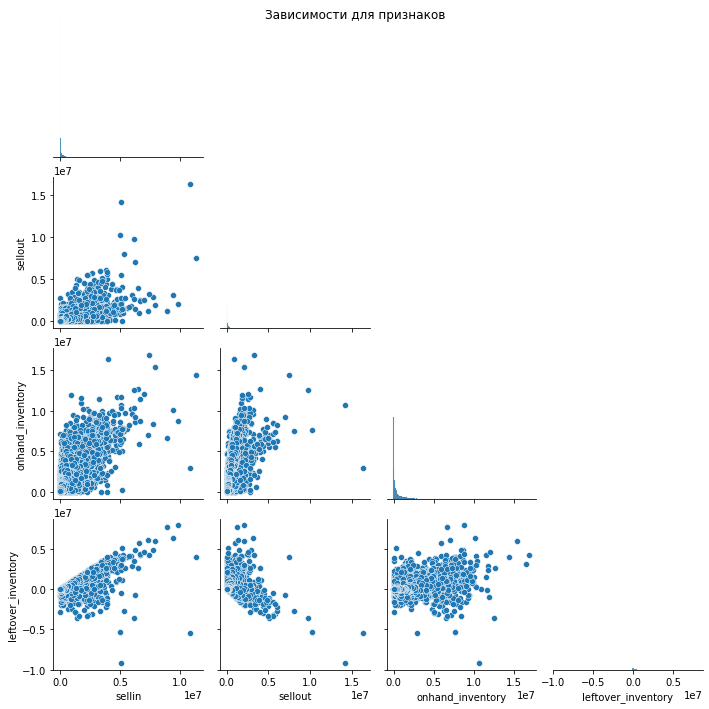

In [74]:
sns.pairplot( # матрица диаграмм рассеяния из Seaborn
data = train[['sellin','sellout','onhand_inventory','leftover_inventory',]], # данные
corner = True # матрица симметрична, не будем выводить лишние графики
).fig.suptitle( # настройки заголовка
'Зависимости для признаков' # заголовок
#y = 1.08 # расположение
);

In [50]:
train.columns

Index(['sku_name', 'starting_inventory', 'sellin', 'sellin_channel_1',
       'sellin_channel_2', 'sellin_channel_3', 'sellin_channel_4',
       'sellin_channel_5', 'sellin_channel_6', 'sellin_channel_7',
       'sellin_channel_8', 'sellout', 'onhand_inventory', 'leftover_inventory',
       'sellout_channel_1', 'sellout_channel_2', 'sellout_channel_3',
       'sellout_channel_4', 'sellout_channel_5', 'sellout_channel_6',
       'sellout_channel_7', 'sellout_channel_8', 'sellout_channel_9',
       'sellout_channel_10', 'onhand_inventory_channel_1',
       'onhand_inventory_channel_2', 'onhand_inventory_channel_3',
       'onhand_inventory_channel_4', 'onhand_inventory_channel_5',
       'onhand_inventory_channel_6', 'onhand_inventory_channel_7',
       'onhand_inventory_channel_8', 'onhand_inventory_channel_9',
       'onhand_inventory_channel_10', 'price', 'month', 'year',
       'product_lifecycle_stage', 'FLAG100', 'disc_month', 'cum_disc',
       'CAT_GENDER_BOTH', 'CAT_GENDER_MEN',

In [65]:
temp = train[train.year>=2021]

In [64]:
train[(train.year>=2021) & (train.sku_name == 'YOSHWARDTERR')]

Empty DataFrame
Columns: [sku_name, starting_inventory, sellin, sellin_channel_1, sellin_channel_2, sellin_channel_3, sellin_channel_4, sellin_channel_5, sellin_channel_6, sellin_channel_7, sellin_channel_8, sellout, onhand_inventory, leftover_inventory, sellout_channel_1, sellout_channel_2, sellout_channel_3, sellout_channel_4, sellout_channel_5, sellout_channel_6, sellout_channel_7, sellout_channel_8, sellout_channel_9, sellout_channel_10, onhand_inventory_channel_1, onhand_inventory_channel_2, onhand_inventory_channel_3, onhand_inventory_channel_4, onhand_inventory_channel_5, onhand_inventory_channel_6, onhand_inventory_channel_7, onhand_inventory_channel_8, onhand_inventory_channel_9, onhand_inventory_channel_10, price, month, year, product_lifecycle_stage, FLAG100, disc_month, cum_disc, CAT_GENDER_BOTH, CAT_GENDER_MEN, CAT_GENDER_WOMEN, Weeks, prefix]
Index: []

[0 rows x 46 columns]

In [67]:
for sku_name in test.sku_name.unique():
    temptemp = temp[(temp.year>=2021) & (temp.sku_name == sku_name)]
    print(f'{sku_name}: {temptemp.product_lifecycle_stage.unique()}')

YOSHTLYNYOSHZZ: ['K' 'N']
YOSHRENECARL: ['L' 'N']
YOSHLEENBART: ['L' 'N']
YOSHILSEHOWAZZ: ['K' 'T']
WHITSHIAALBEZZ: ['W']
WHITOLPHKAITZZ: ['R' 'W']
WHITESHAMITCZZ: ['N' 'M']
WHITENNEANHZZ: ['K' 'S' 'W']
WHITEENAREVA: ['L' 'N']
WALLUTHEGRAHZZ: ['N' 'W']
WALLUDIETERRZZ: ['S' 'W']
WALLNALDDUAN: ['N']
WALLLIAMSUDI: ['L']
WALLHORARUBYZZ: ['K' 'T']
WALLHAELARLEZZ: ['A']
WALLANDALEAN: ['L']
TRANNARDCARLZZ: ['A' 'L']
TRANETTEALONZZ: ['R' 'N']
THORRISAJULIZZ: ['N']
TERRUTHEHARLZZ: ['K' 'N']
TERRETHAARMA: ['L']
SUNDSHIESUNDZZ: ['N' 'L']
SUNDSAACETHAZZ: ['K' 'N']
SUNDROBBART: ['N']
SUNDRENEASHLZZ: ['R' 'N']
SUNDBARTLEATZZ: ['K' 'R' 'N']
SUDIUANEARLE: ['L']
SUDISHIEELLY: ['L']
SUDIEIDAYOSH: ['L']
SIGRRTIENOLAZZ: ['N' 'W']
SIGRREYHOWA: ['L']
SIGRMULASUDI: ['W']
SIGRMBERCARL: ['L']
SIGRERRYARTIZZ: ['R' 'N' 'W']
SHERTTNYNOLAZZ: ['K' 'R' 'N']
SHERANDARIGOZZ: ['K' 'T']
SAMATNEYANTOZZ: ['K' 'T']
SAMATINEWHIT: ['L']
SAMARTHAMAXIZZ: ['K' 'T']
SAMANDAYLAZA: ['L']
SAMABARTRUTHZZ: ['N' 'W']
RUTHMULASUDI: ['L

In [61]:
temp

sku_name  starting_inventory  sellin  sellin_channel_1  \
44897  ABEAHAMASHL              503461   28364                 0   
44898  ABEAHAMASHL              497383   12156              1013   
44899  ABEAHAMASHL              565254   42546             15195   
44900  ABEAHAMASHL              578423    7091              1013   
44901  ABEAHAMASHL              560189   24312              7091   
44902  ABEAHAMASHL              432551  156002            101300   
44903  ABEAHAMASHL              406213   34442              6078   
44904  ABEAHAMASHL              375823   38494                 0   
44905  ABEAHAMASHL              400135   29377              1013   
44906  ABEAHAMASHL              410265   18234                 0   

       sellin_channel_2  sellin_channel_3  sellin_channel_4  sellin_channel_5  \
44897              5065                 0                 0                 0   
44898                 0                 0                 0              5065   
44899             20260                 0                 0                 0   
44900                 0                 0                 0                 0   
44901                 0                 0                 0                 0   
44902             10130                 0                 0                 0   
44903                 0                 0                 0                 0   
44904                 0                 0             24312                 0   
44905                 0                 0              1013                 0   
44906                 0                 0              1013                 0   

       sellin_channel_6  sellin_channel_7  ...  year  product_lifecycle_stage  \
44897             18234                 0  ...  2021                        W   
44898              3039                 0  ...  2021                        W   
44899              5065                 0  ...  2021                        W   
44900              5065                 0  ...  2021                        W   
44901              1013                 0  ...  2021                        W   
44902              1013                 0  ...  2021                        W   
44903              4052                 0  ...  2021                        W   
44904             14182                 0  ...  2021                        W   
44905              6078                 0  ...  2021                        W   
44906             17221                 0  ...  2021                        W   

        FLAG100  disc_month  cum_disc  CAT_GENDER_BOTH  CAT_GENDER_MEN  \
44897  0.250000           1         1                0               0   
44898  0.250000           0         1                0               0   
44899  0.000000           0         1                0               0   
44900  0.500000           0         0                0               0   
44901  0.000000           0         0                0               0   
44902  0.000000           0         0                0               0   
44903  0.333333           0         0                0               0   
44904  0.400000           1         1                0               0   
44905  0.000000           0         1                0               0   
44906  0.452381           1         1                0               0   

       CAT_GENDER_WOMEN  Weeks  prefix  
44897                 1      1    ABEA  
44898                 1      0    ABEA  
44899                 1      0    ABEA  
44900                 1      0    ABEA  
44901                 1      1    ABEA  
44902                 1      0    ABEA  
44903                 1      0    ABEA  
44904                 1      1    ABEA  
44905                 1      0    ABEA  
44906                 1      1    ABEA  

[10 rows x 46 columns]

### Изучение признаков, отвечающих за скидки

In [88]:
def make_ts(observations, ds, sku_name='', window_size=2, method = 'linear'):
    observations.reset_index(drop=True, inplace=True)
    ts_before_fill = []
    for i in range(len(observations)):
        try:
            n_missing_values =  (ds[i+1] - ds[i] - 1).astype('int')
            ts_before_fill += [observations[i]] + [np.nan]*n_missing_values
        except:
            ts_before_fill += [observations[i]]
    date_count=(max(ds)-min(ds)).astype('int')
    ds_for_ts=np.array([min(ds)+i for i in range(0, date_count+1)])
    ts_before_fill = pd.Series(ts_before_fill, index = ds_for_ts)
    ts_after_fill = fill_missing_values(ts_before_fill.copy(), window_size, method)
    
    # if sku_name!='':
    #     plt.title(sku_name) #always alone sku_name
    # plt.plot(ts_after_fill, marker = '.', color = 'green')
    # plt.plot(ts_before_fill, marker = 'o', color = 'blue')
    # plt.legend(['filled data','source data'])
    # plt.xticks(rotation=45)
    # plt.show()
    
    return ts_after_fill
    
def fill_missing_values(ts, window_size, method):
    if method == 'linear':
        ts.interpolate(method='linear', inplace=True)
    elif method == 'nofill':
        pass
    return ts
            
    
def linear_interpol(ts, min_row):
    while True:
        if np.isnan(ts[:min_row]).sum() == 0:
            break
        else:
            start = end =-1
            indexes = ts.index.values.astype('datetime64[M]')
            for i in indexes:
                if start == -1 and np.isnan(ts[i]):
                    start = i - 1
                elif start!=-1 and not np.isnan(ts[i]):
                    end = i
                if start!=-1 and end!=-1:
                    ts[start:end].interpolate(method='linear', inplace=True)
                    break

In [80]:
def date_column(x):
    y = x['year']
    m = x['month']
    return pd.Timestamp(y, m, 1)

def date_column_2(x):
    y = x['year']
    m = x['month']
    if y in [2016,2017,2018,2019]:
        return pd.Timestamp(y + 1, m, 1)
    else:
        return pd.Timestamp(y, m, 1)

In [81]:
train['ds'] = train.apply(func = date_column, axis=1)
test['ds'] = test.apply(func = date_column, axis=1)
#train['ds'] = train.apply(func = date_column_2, axis=1)

In [84]:
train['disc_month'].unique() , train['cum_disc'].unique() , 

(array([0, 1], dtype=int64), array([0, 1], dtype=int64))

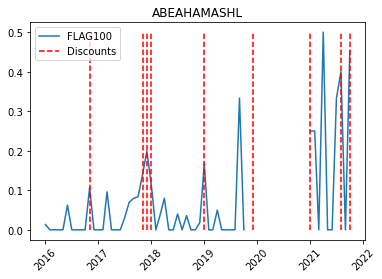

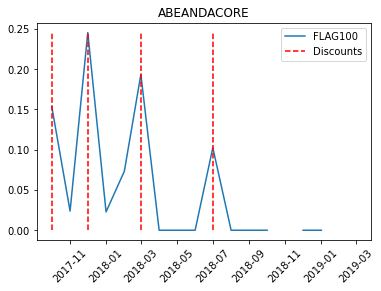

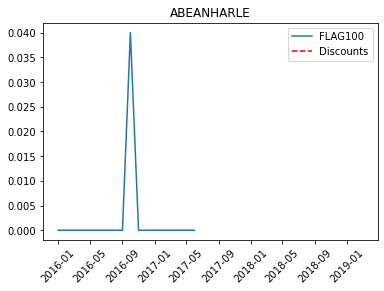

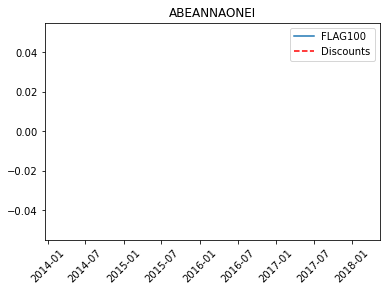

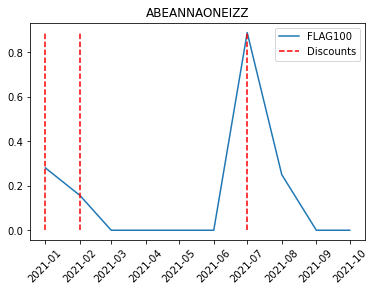

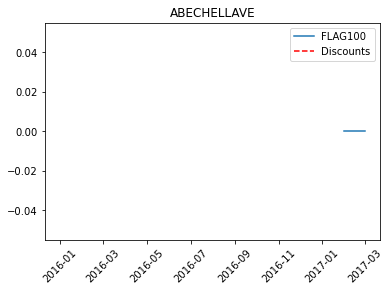

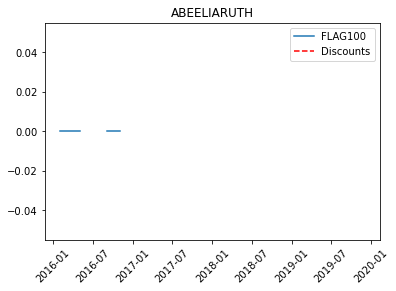

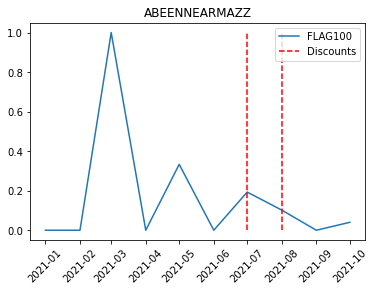

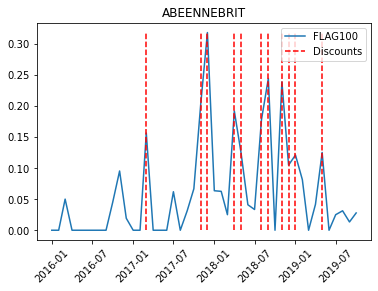

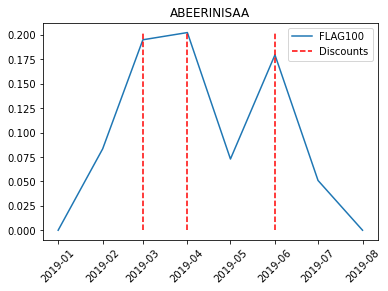

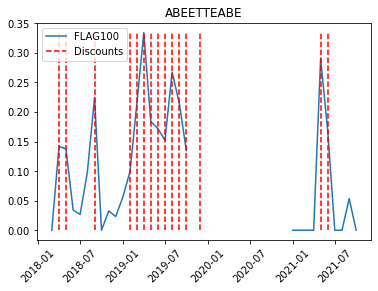

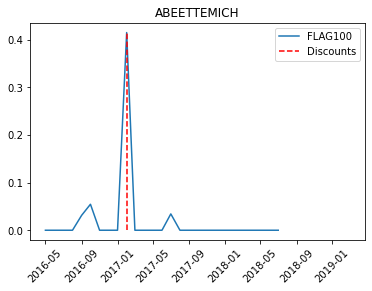

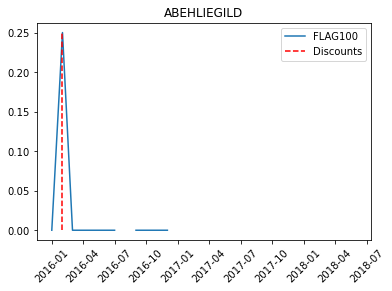

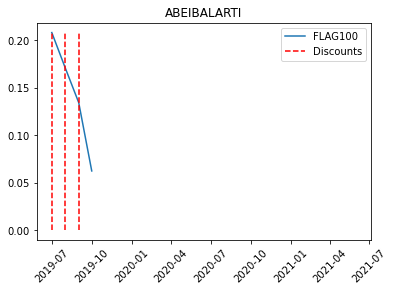

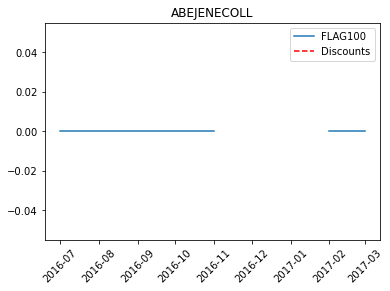

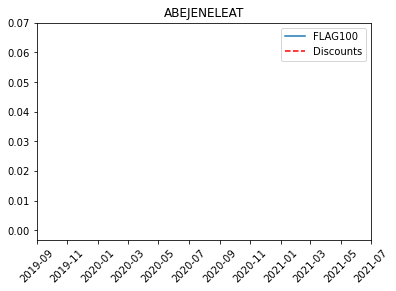

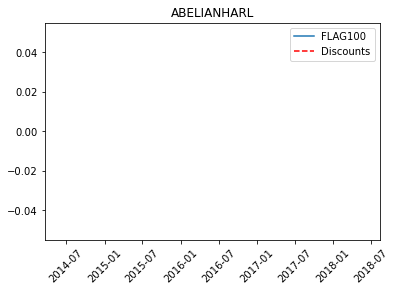

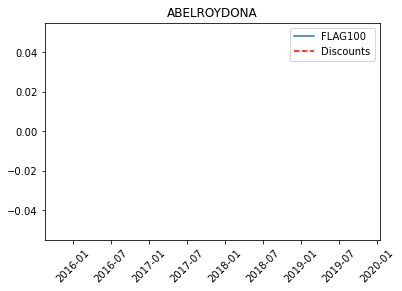

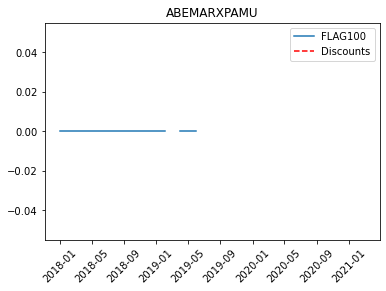

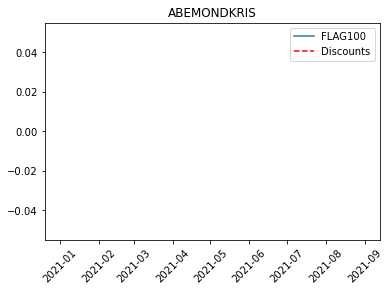

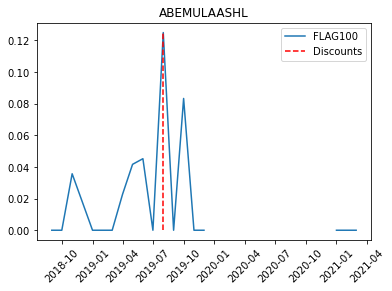

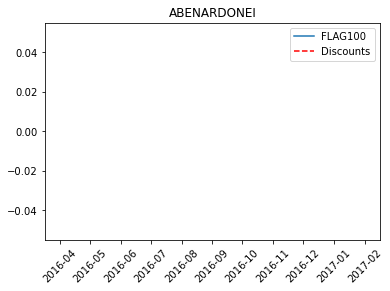

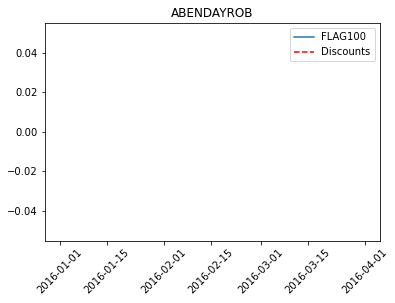

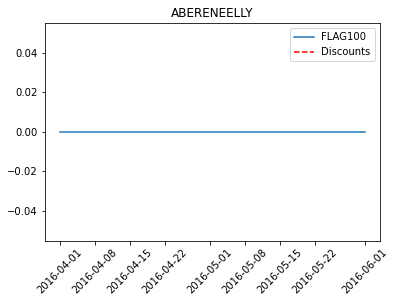

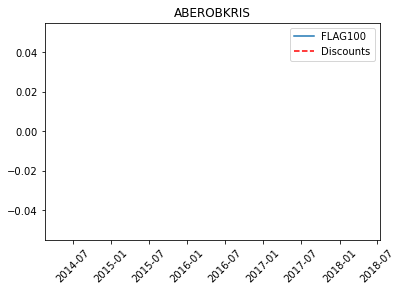

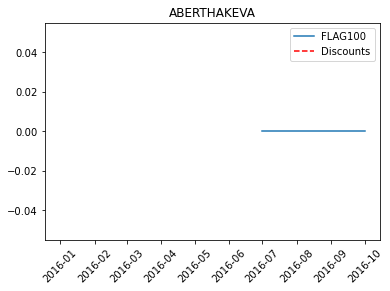

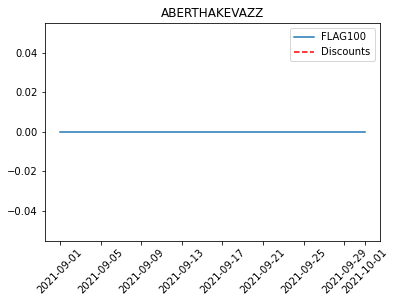

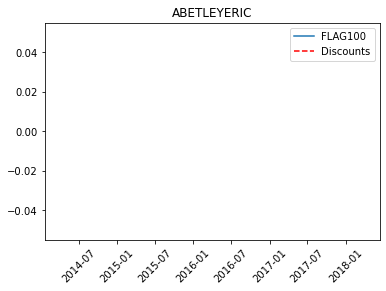

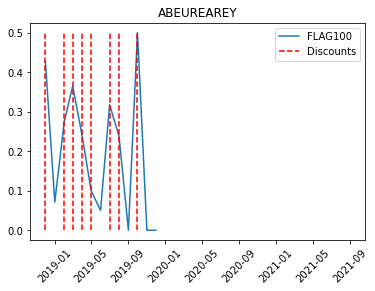

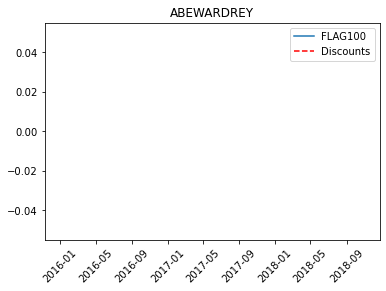

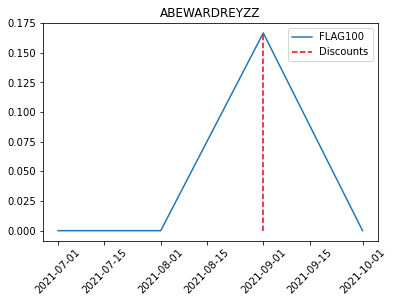

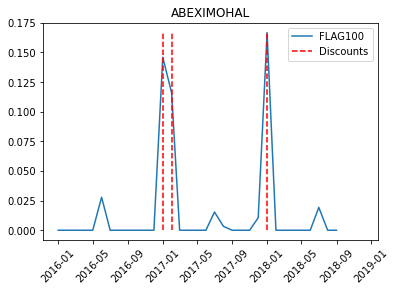

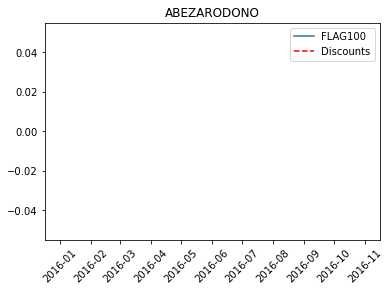

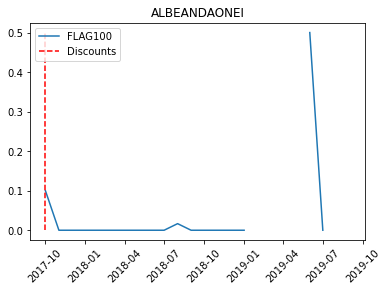

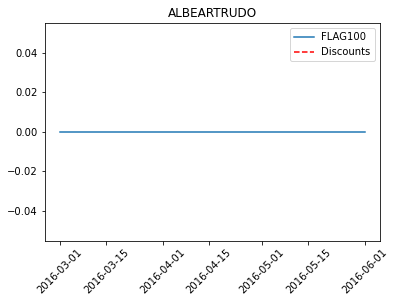

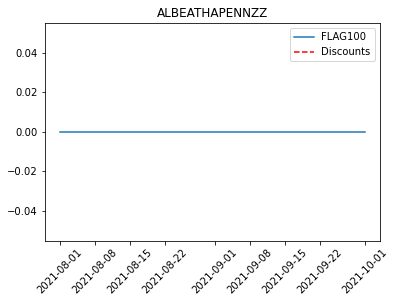

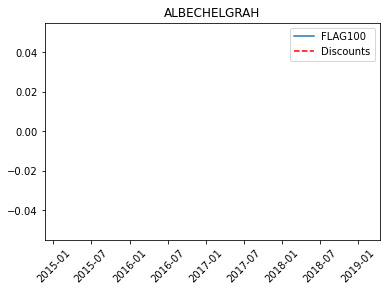

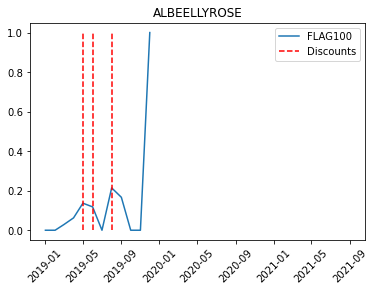

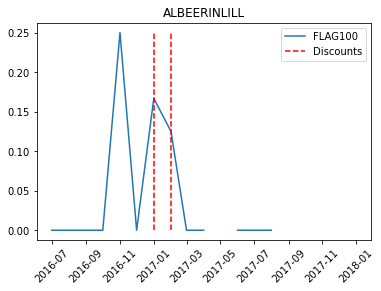

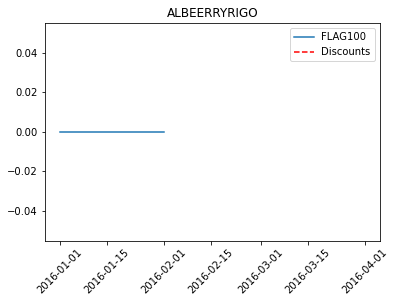

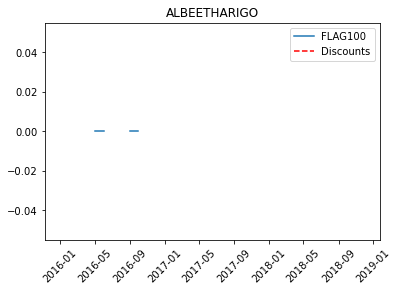

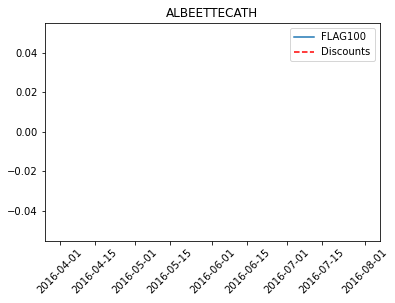

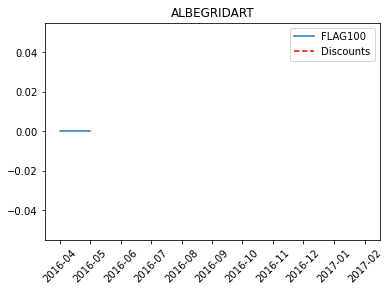

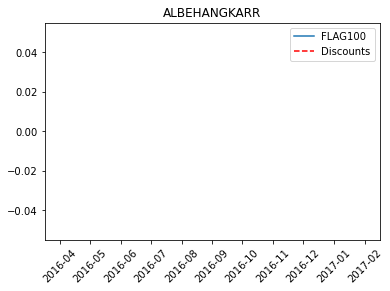

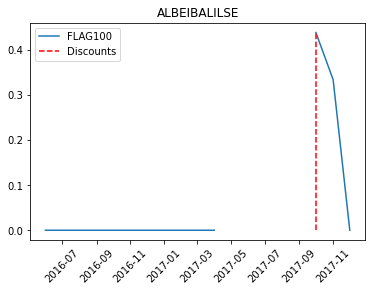

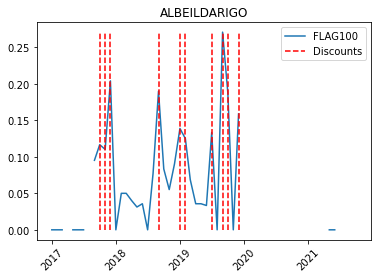

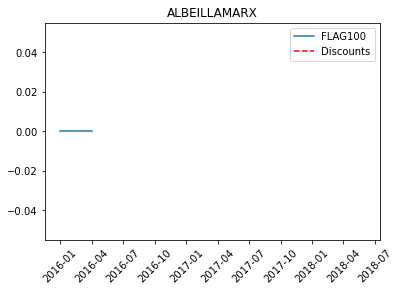

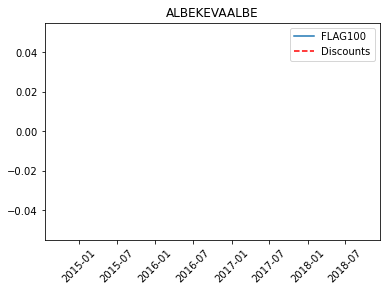

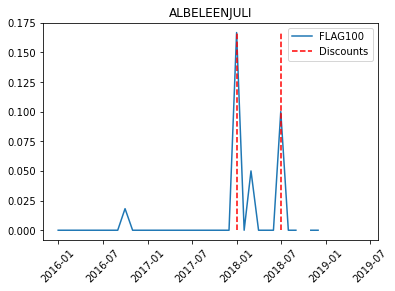

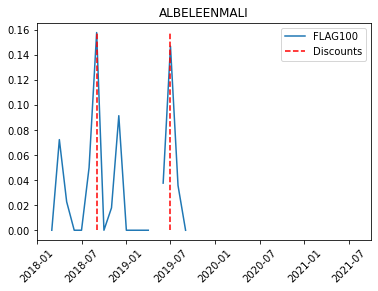

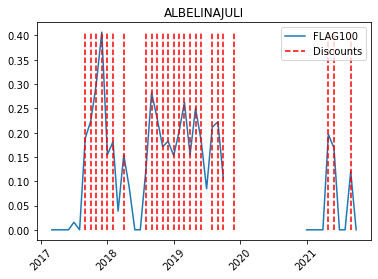

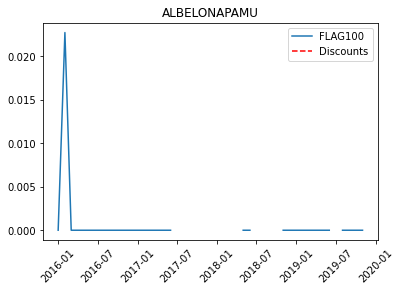

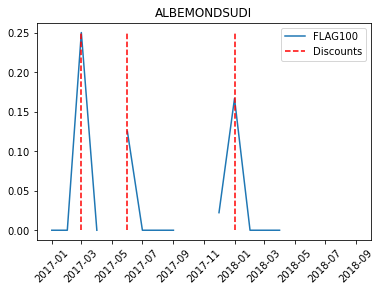

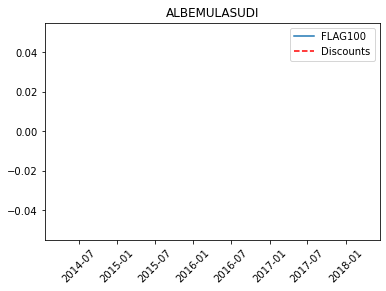

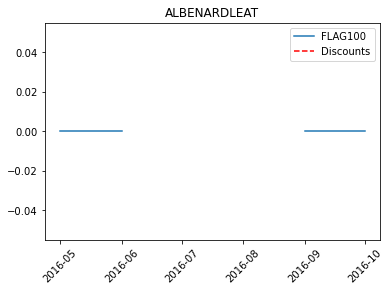

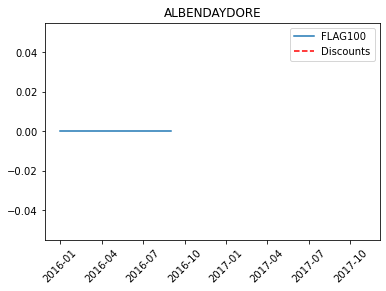

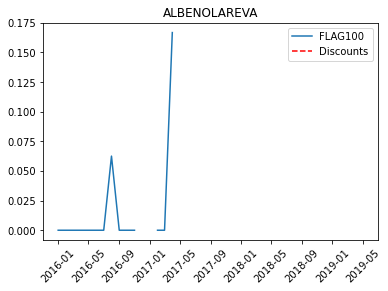

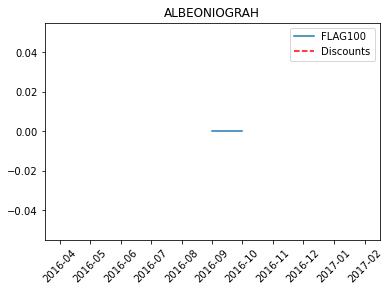

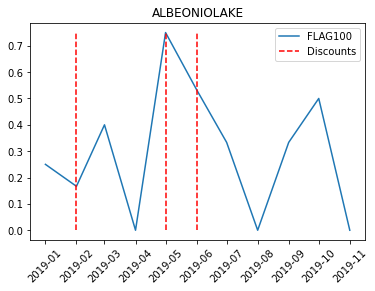

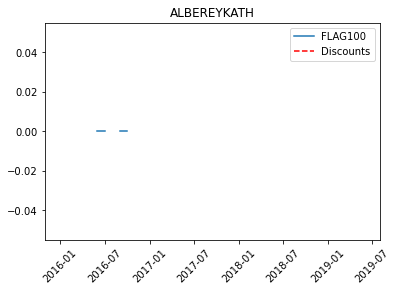

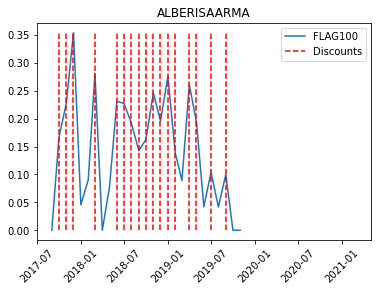

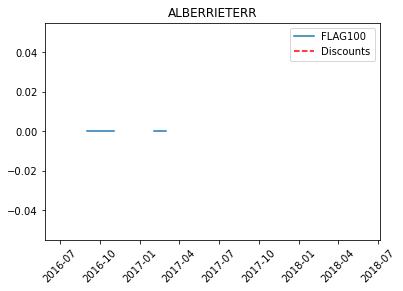

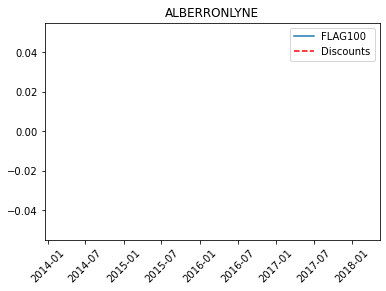

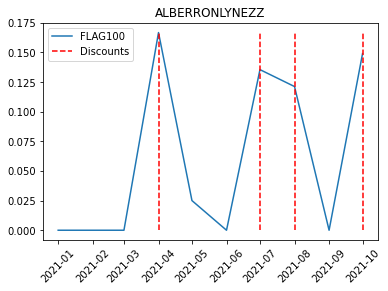

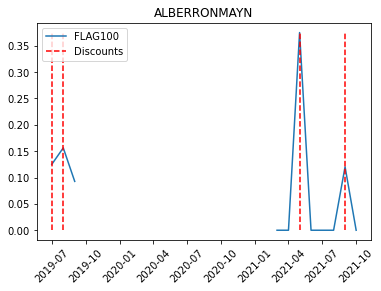

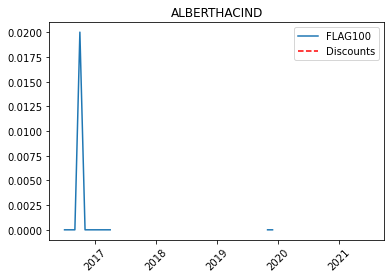

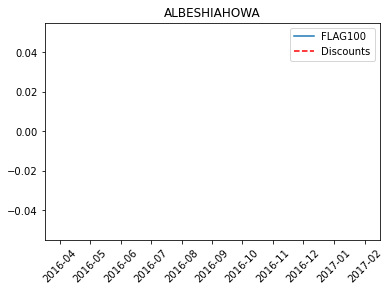

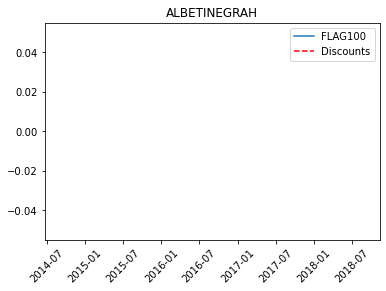

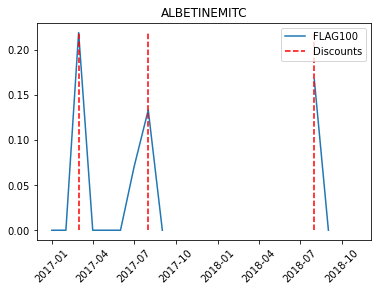

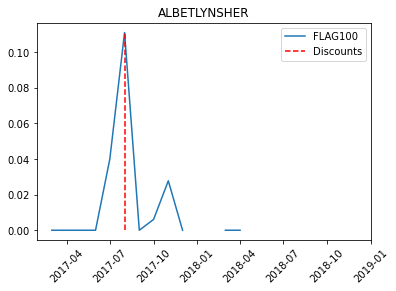

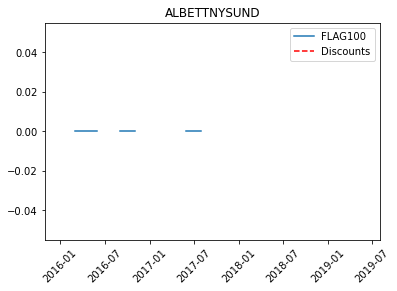

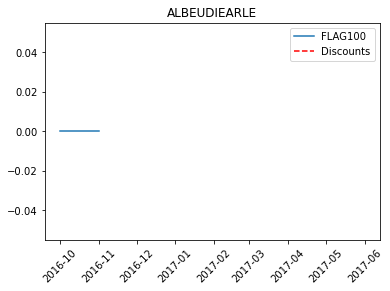

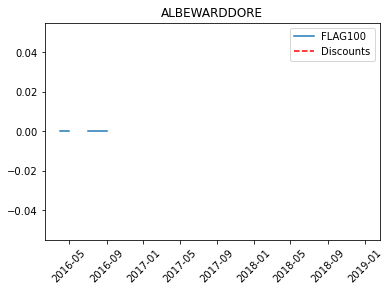

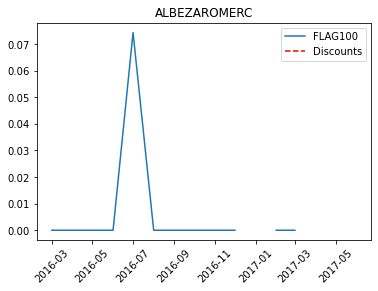

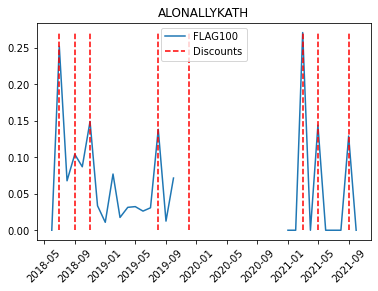

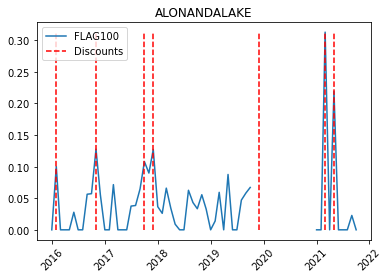

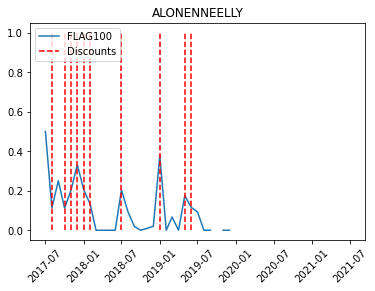

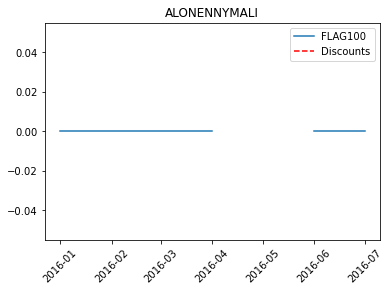

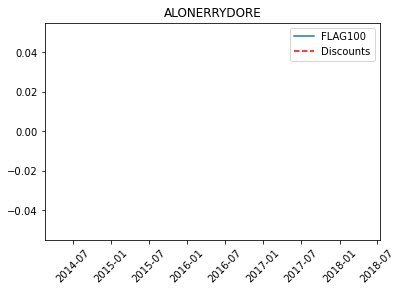

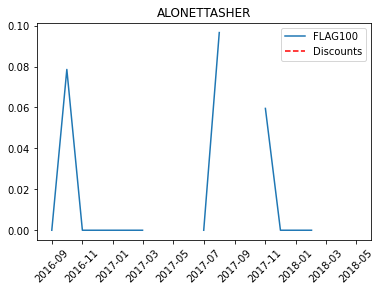

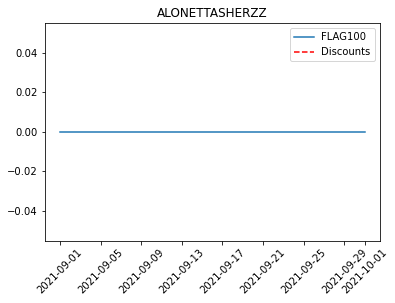

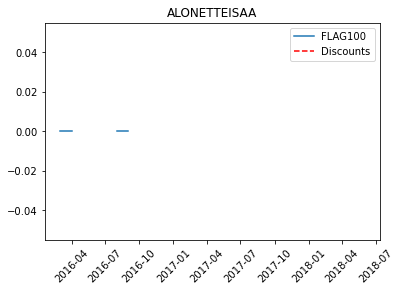

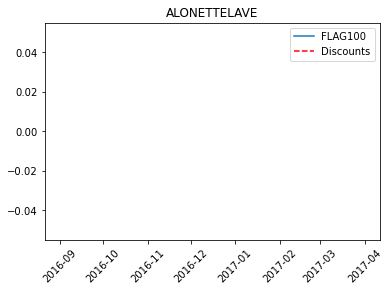

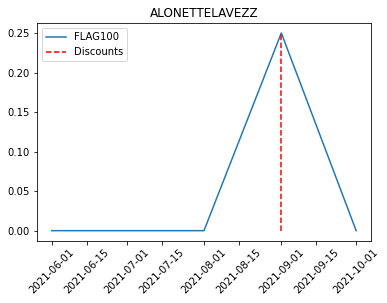

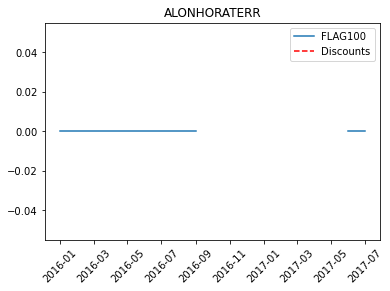

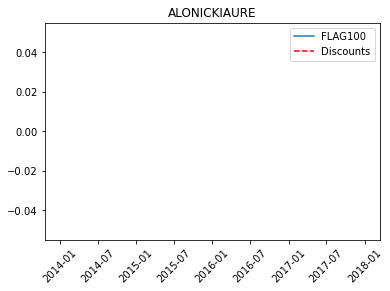

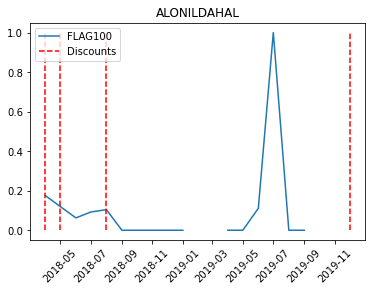

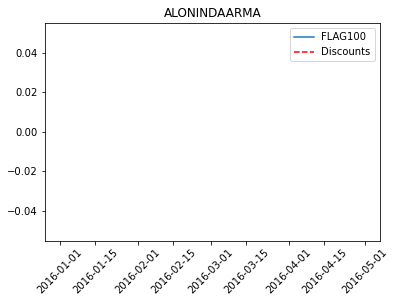

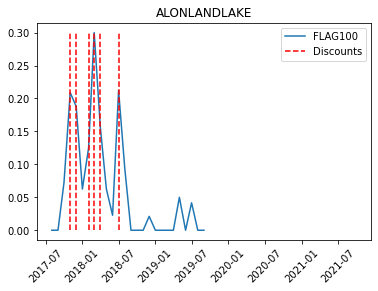

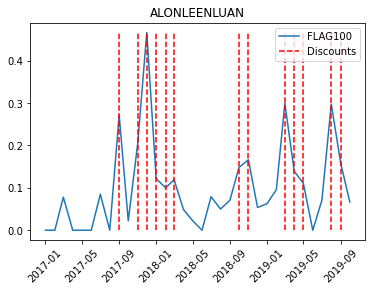

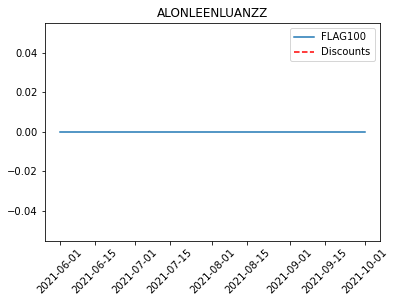

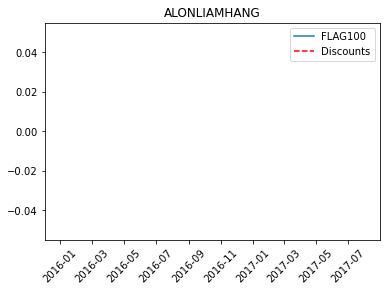

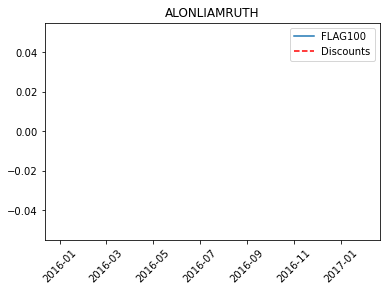

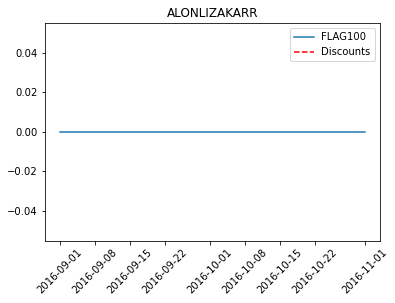

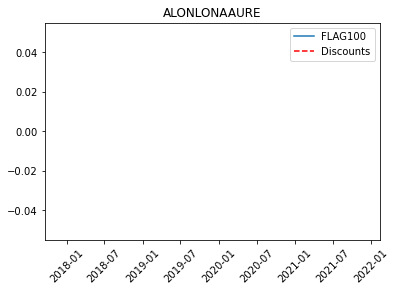

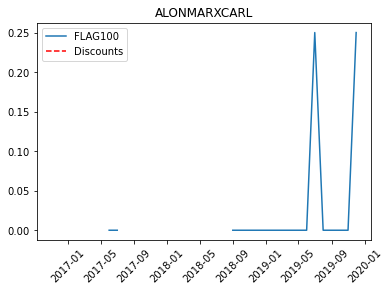

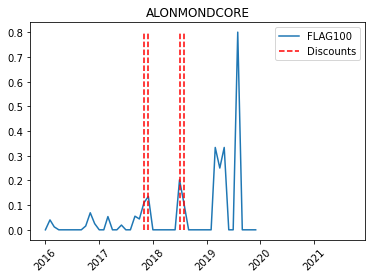

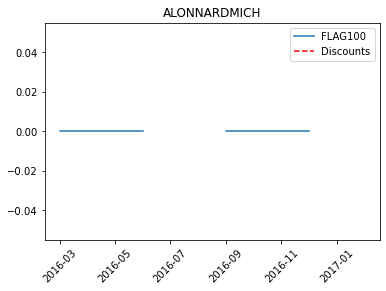

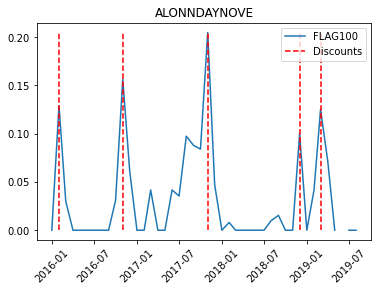

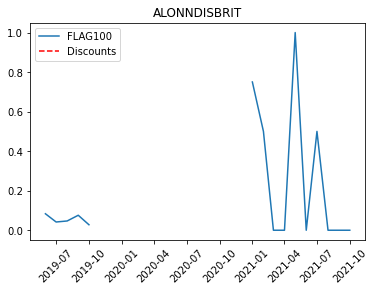

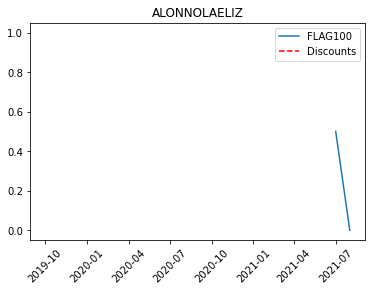

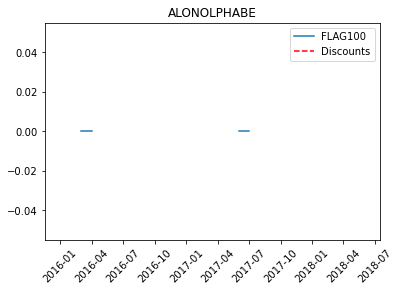

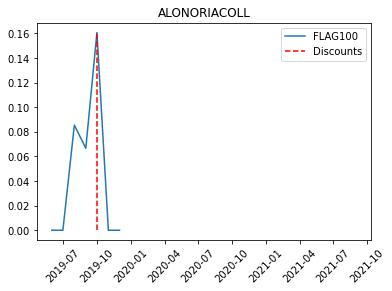

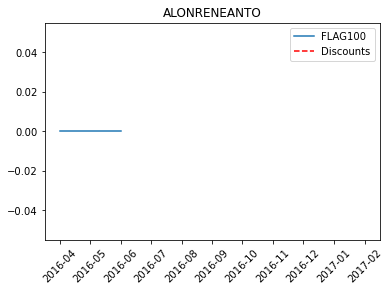

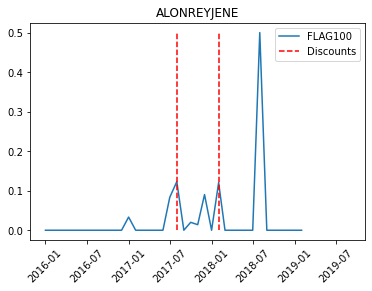

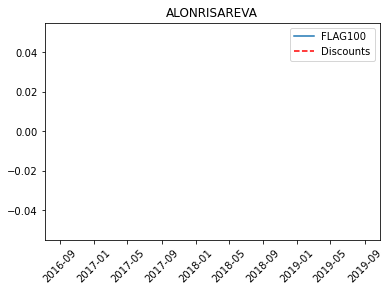

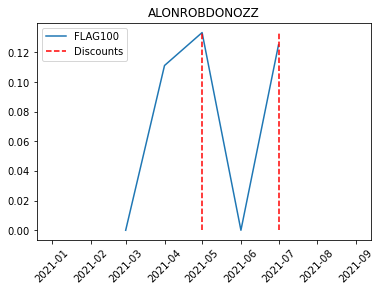

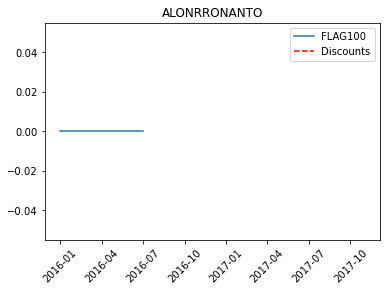

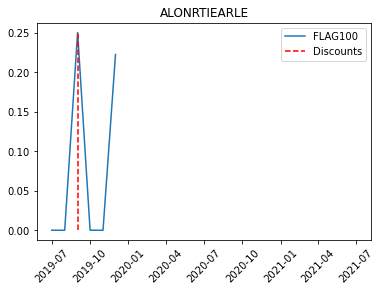

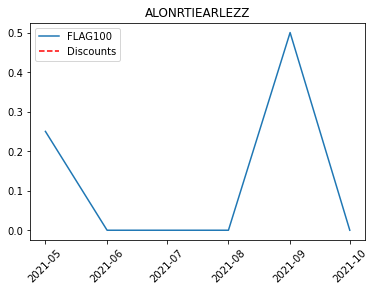

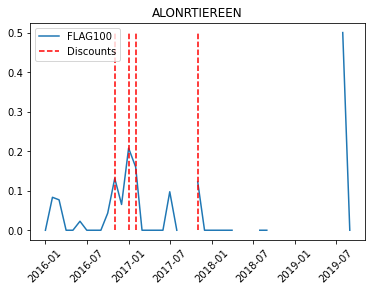

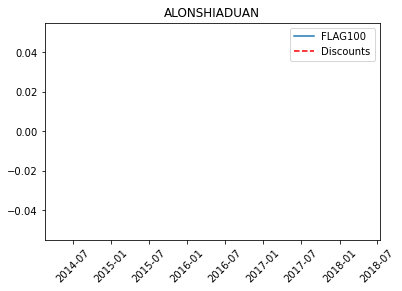

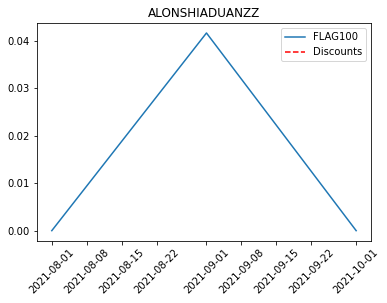

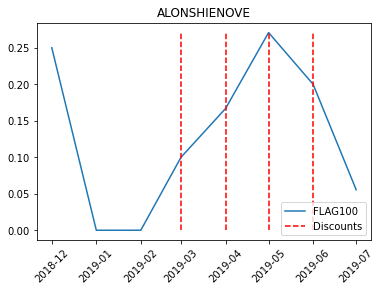

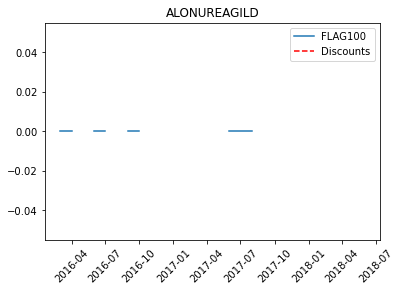

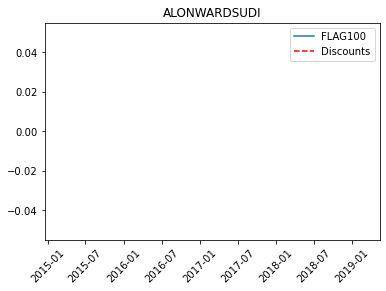

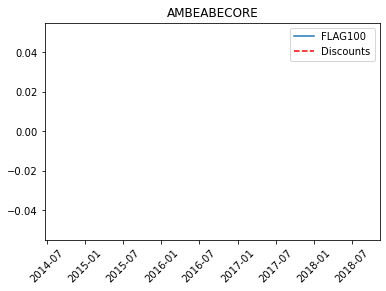

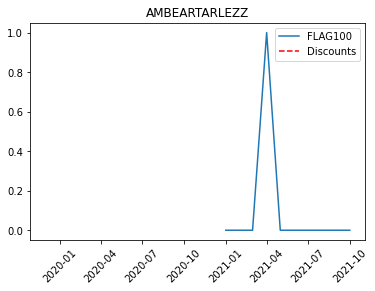

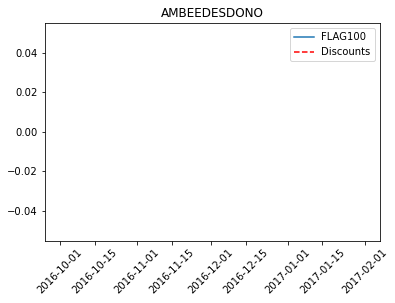

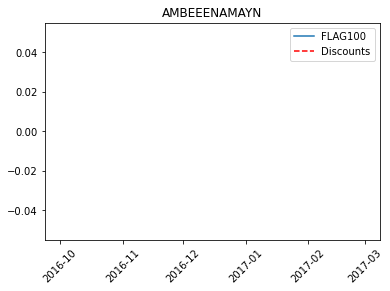

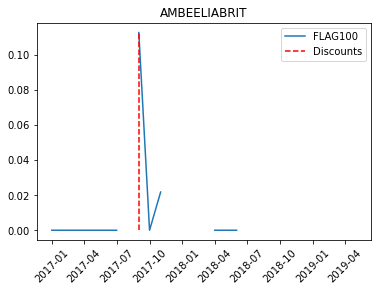

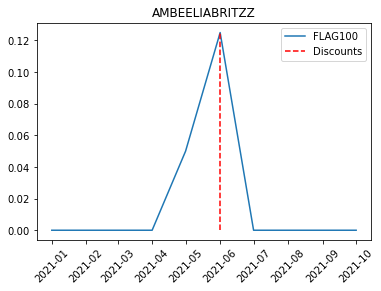

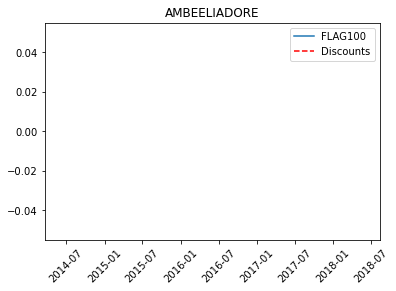

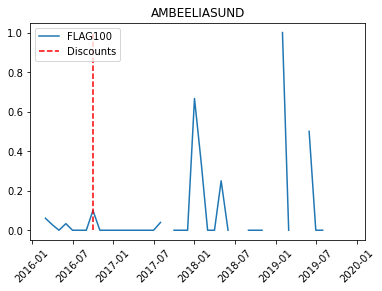

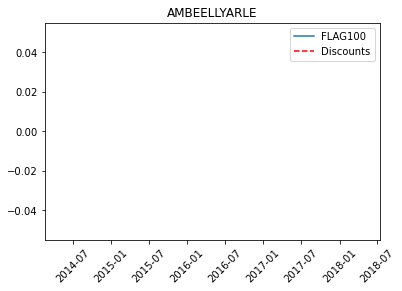

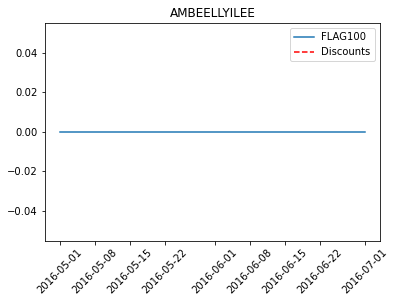

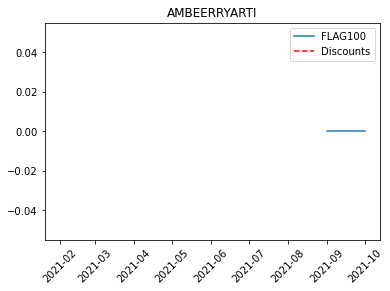

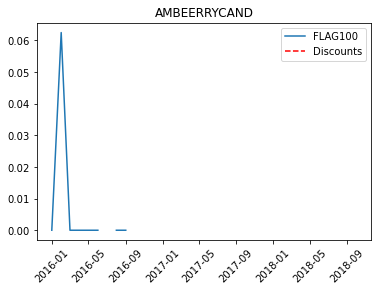

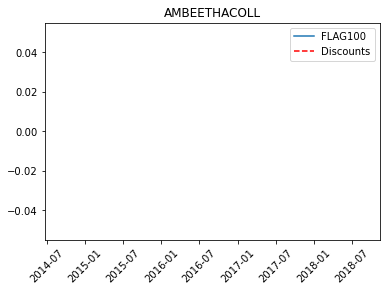

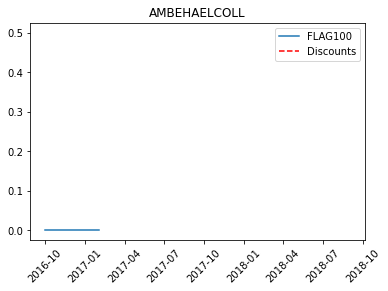

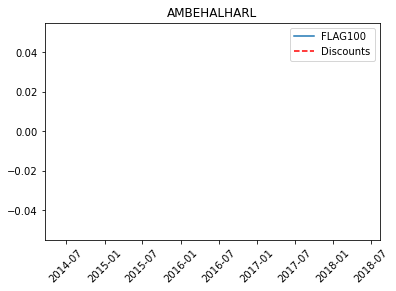

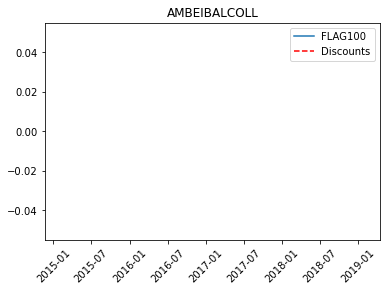

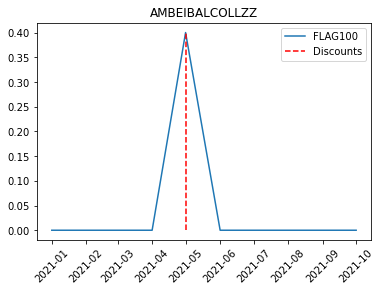

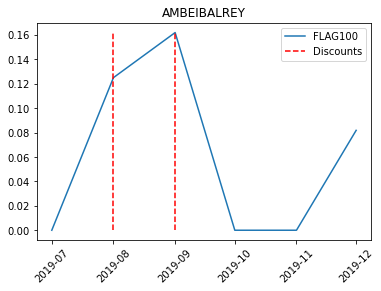

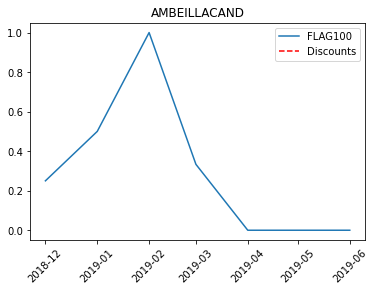

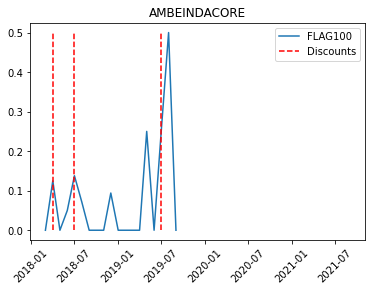

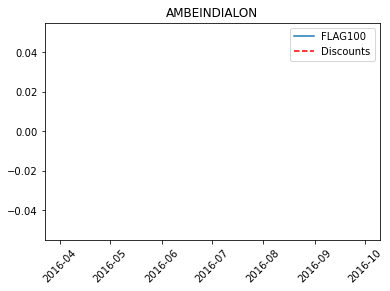

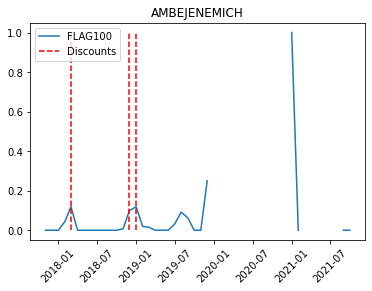

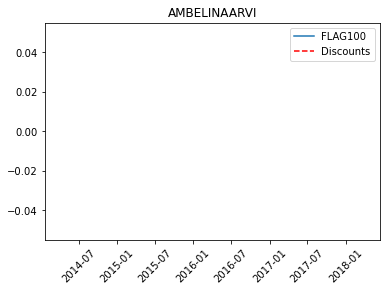

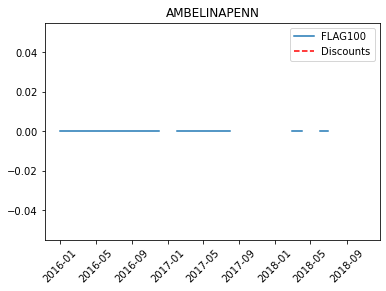

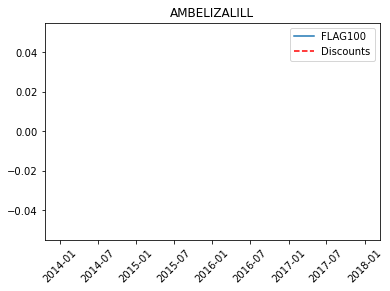

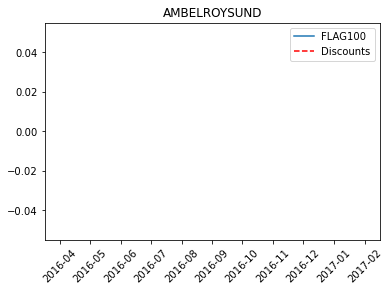

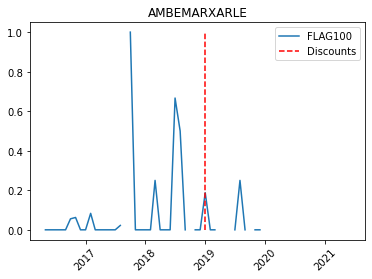

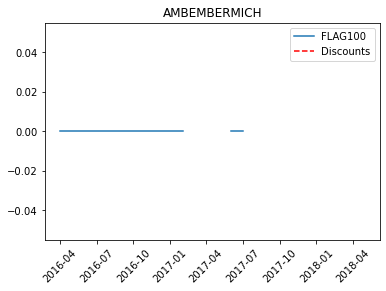

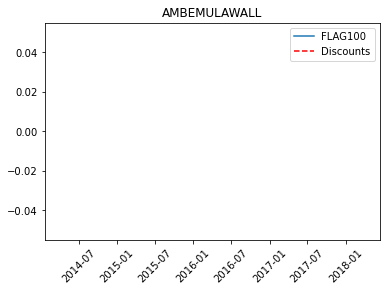

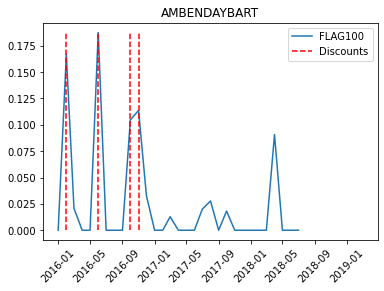

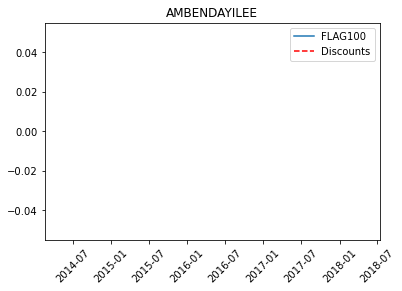

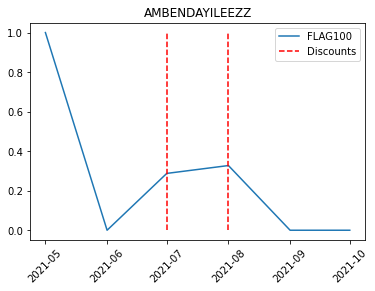

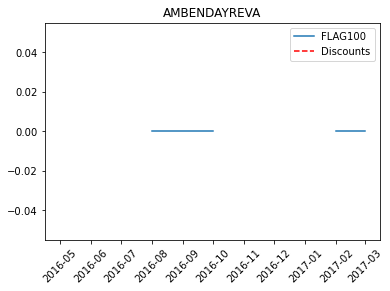

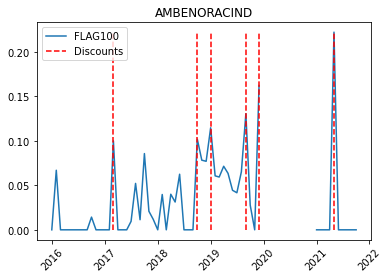

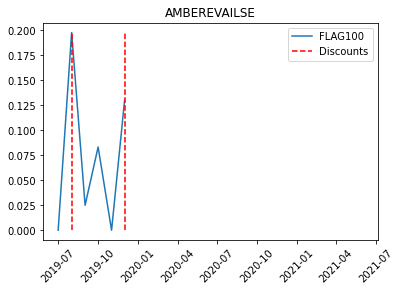

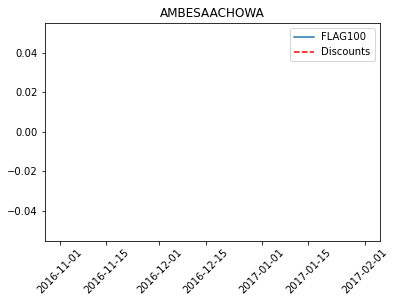

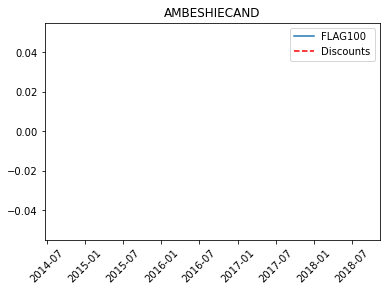

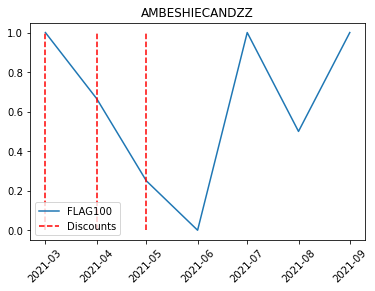

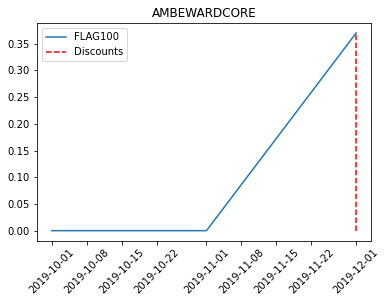

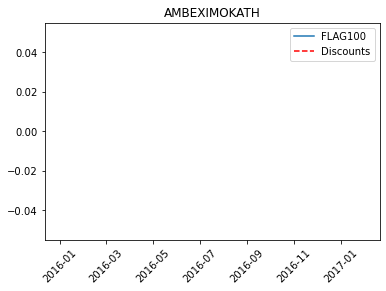

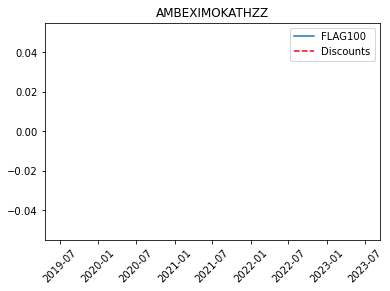

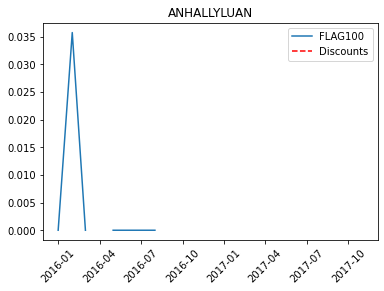

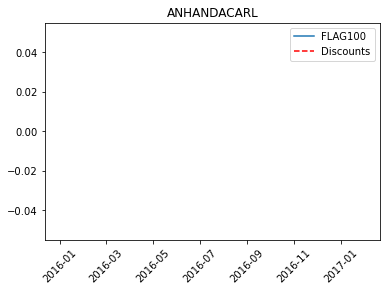

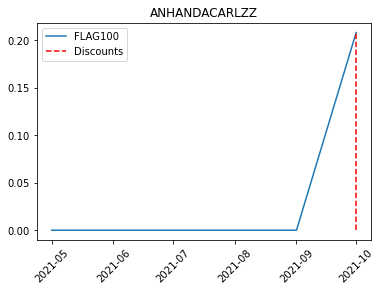

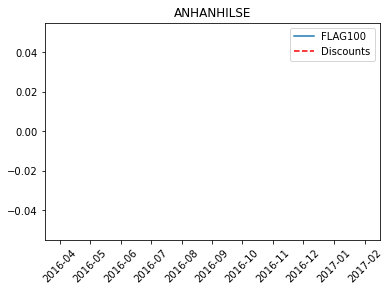

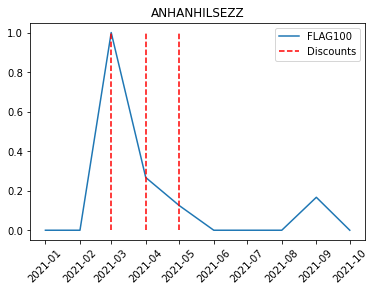

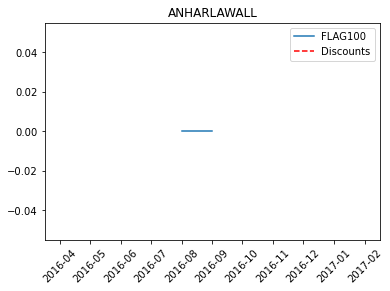

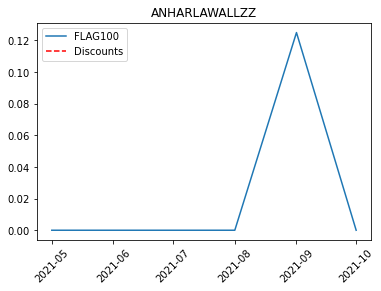

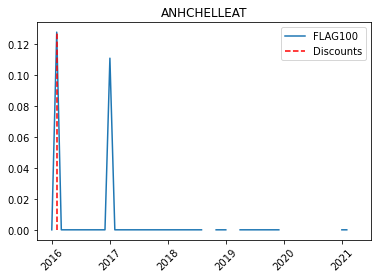

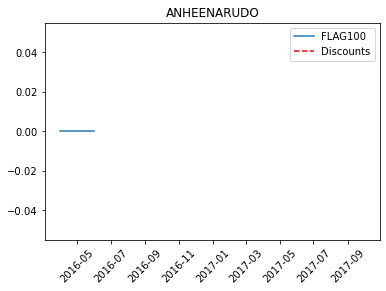

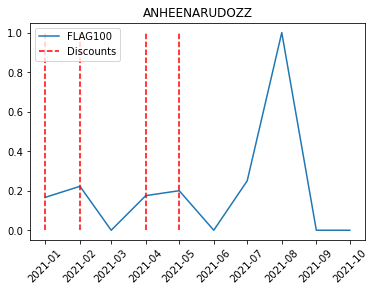

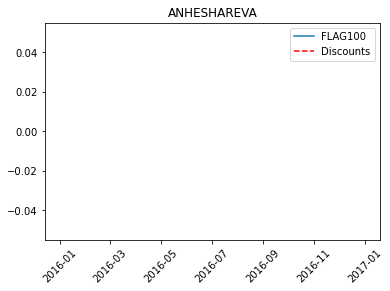

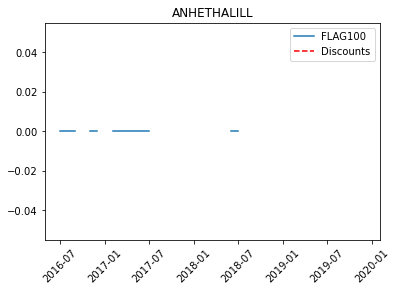

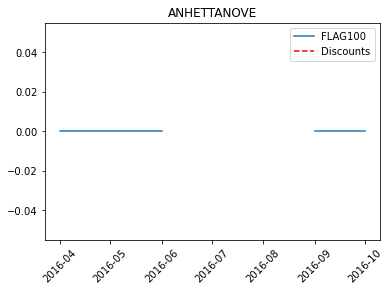

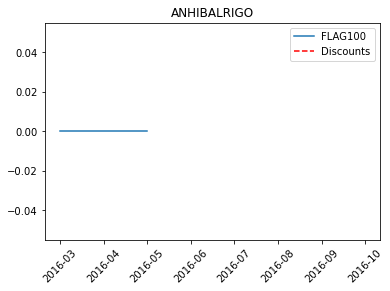

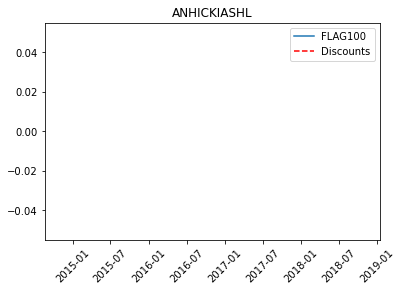

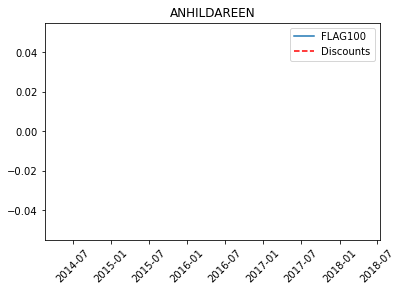

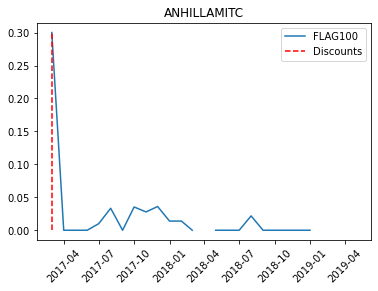

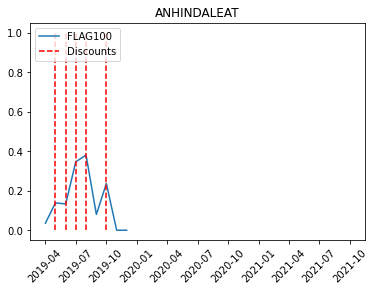

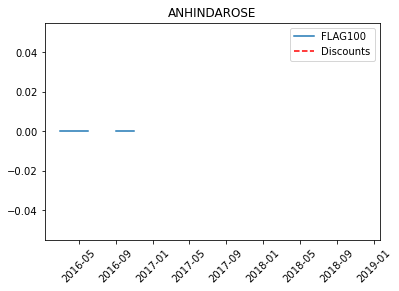

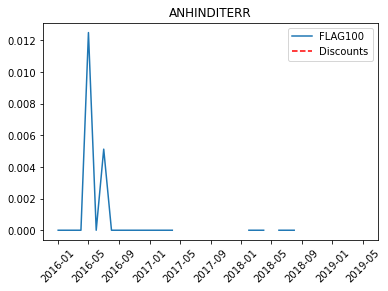

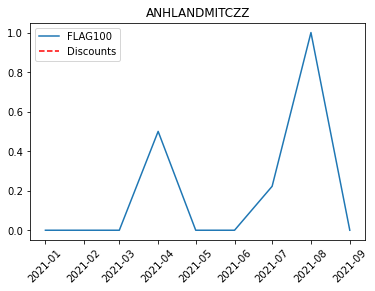

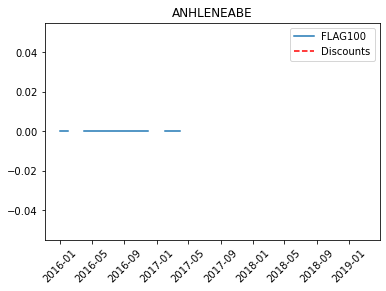

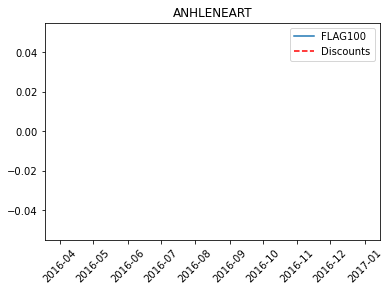

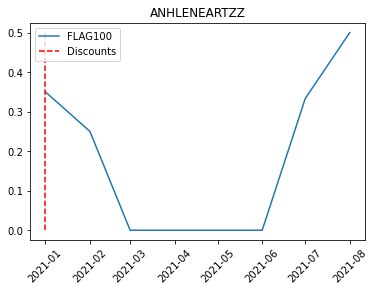

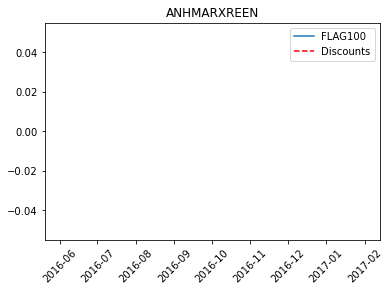

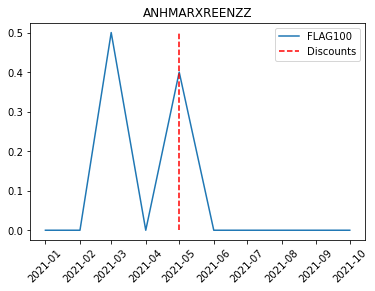

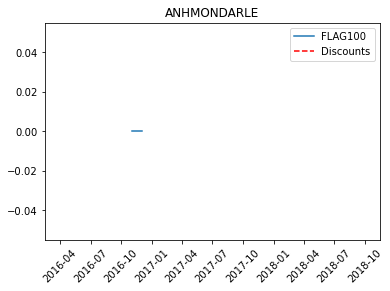

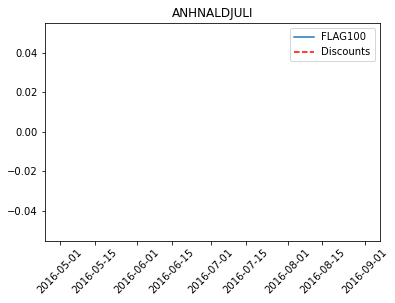

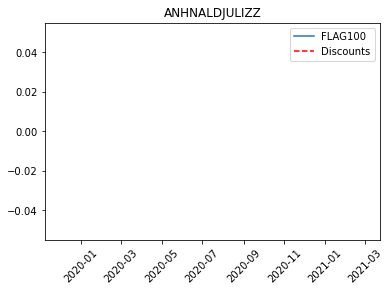

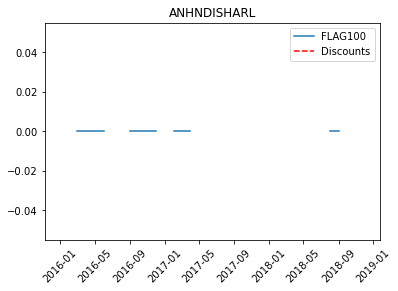

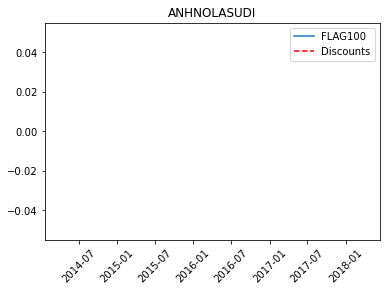

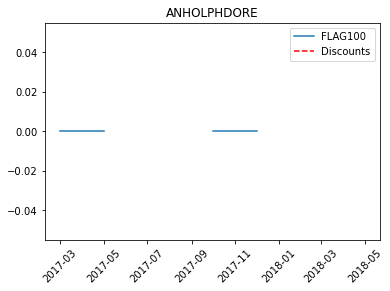

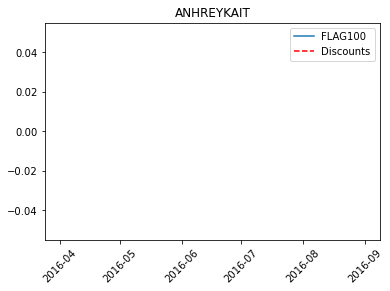

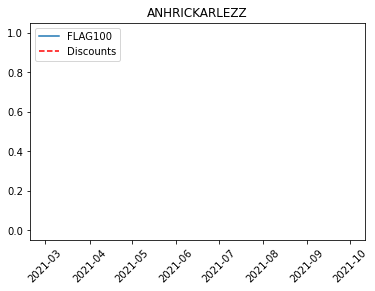

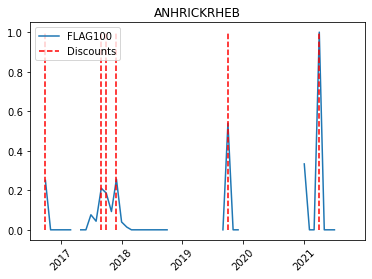

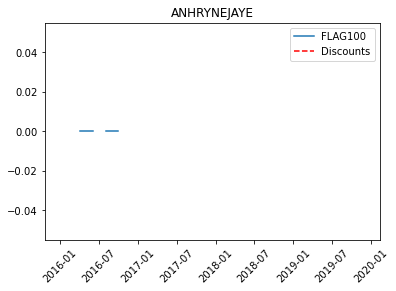

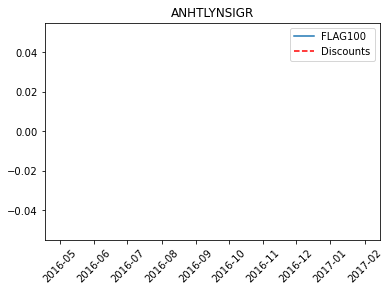

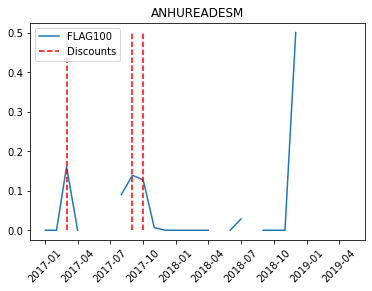

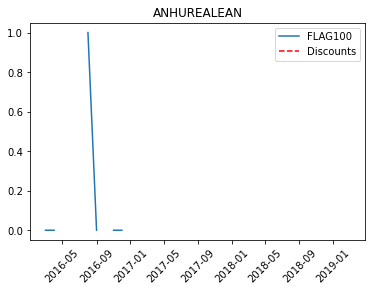

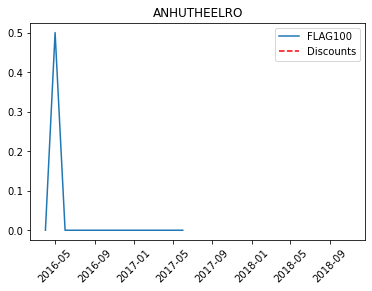

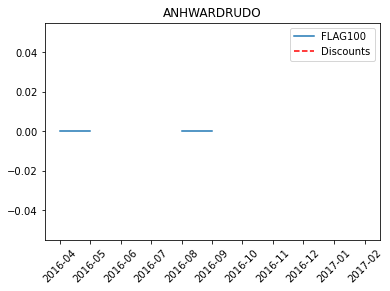

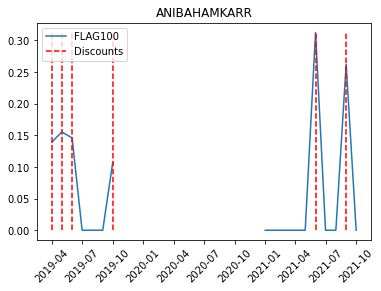

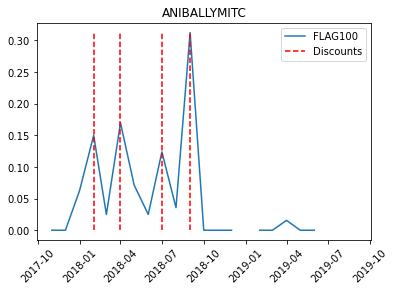

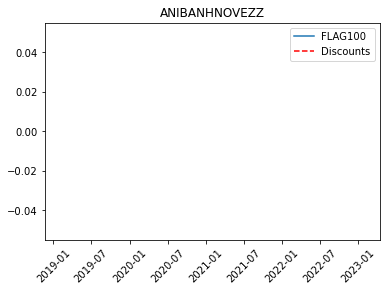

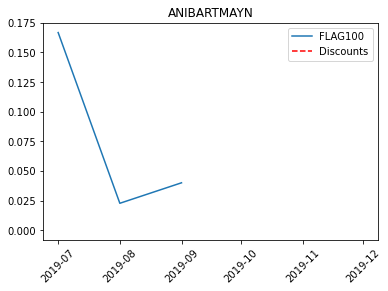

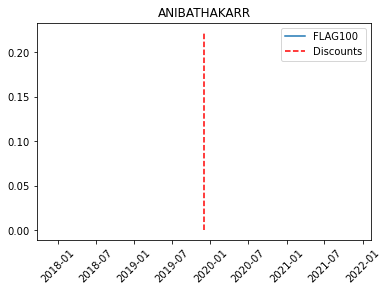

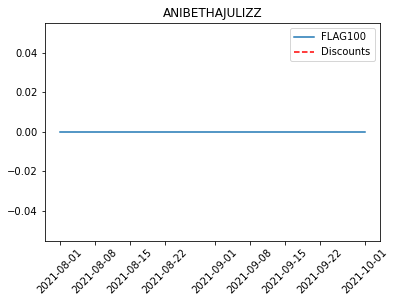

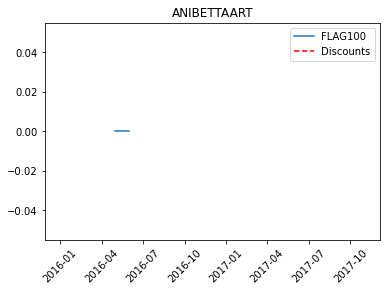

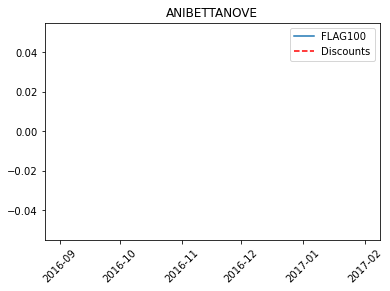

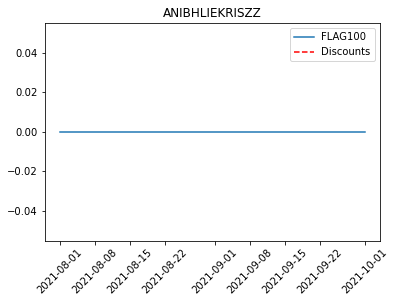

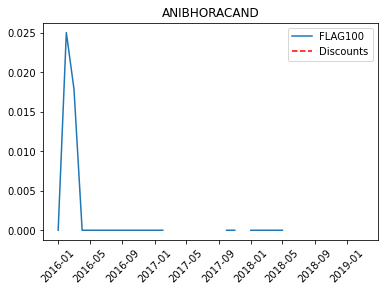

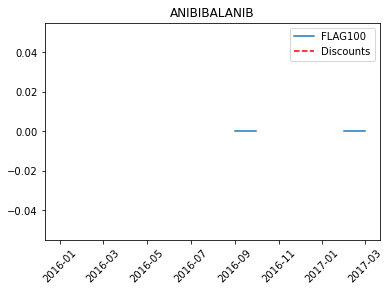

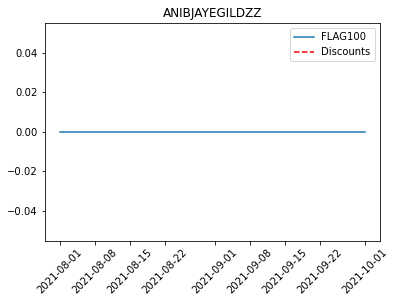

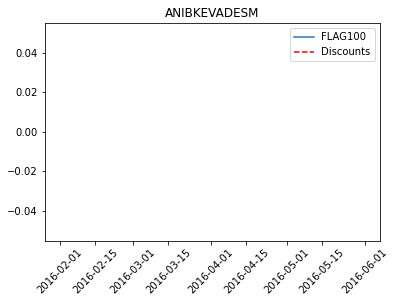

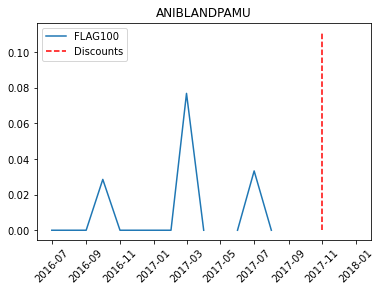

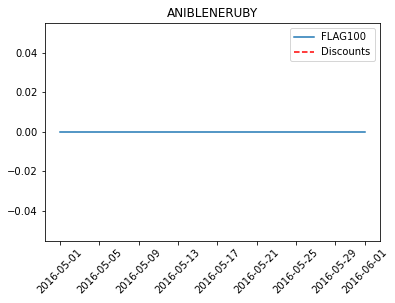

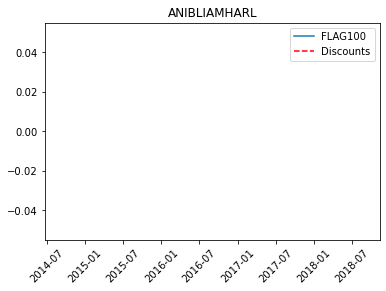

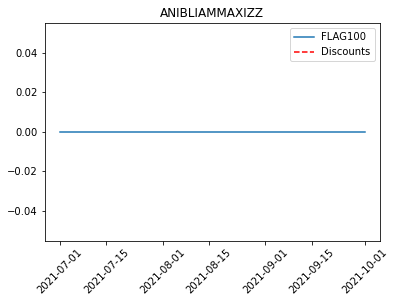

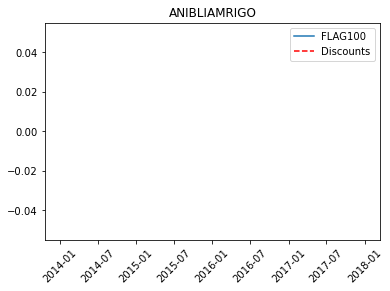

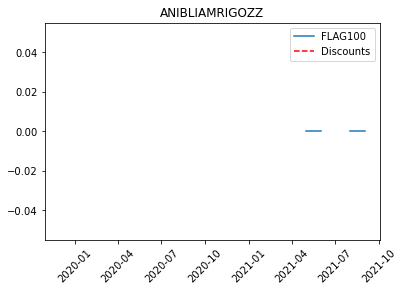

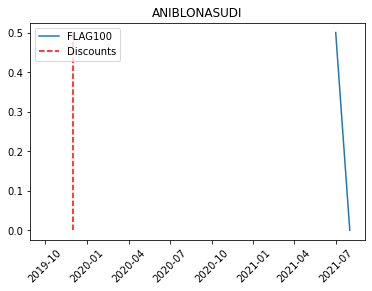

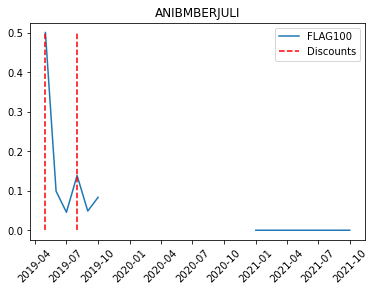

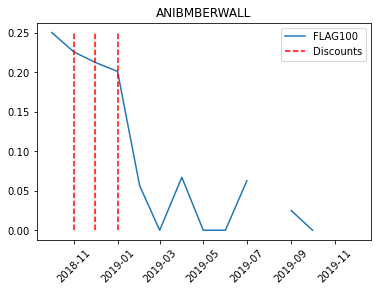

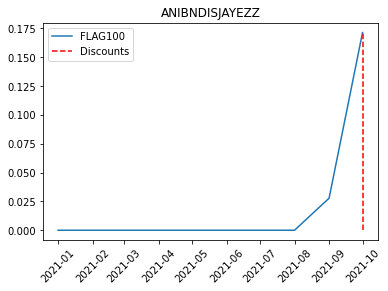

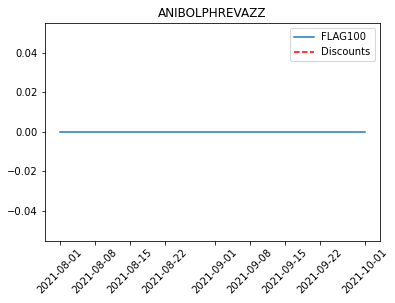

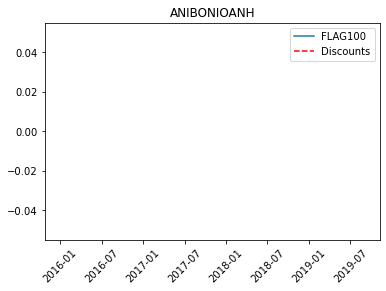

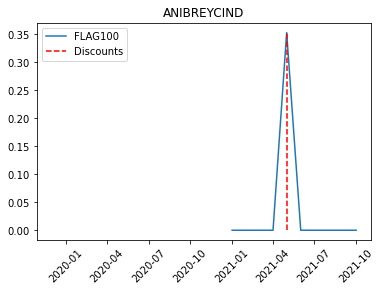

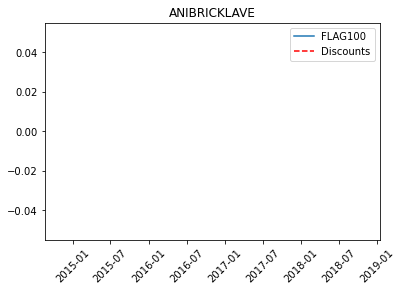

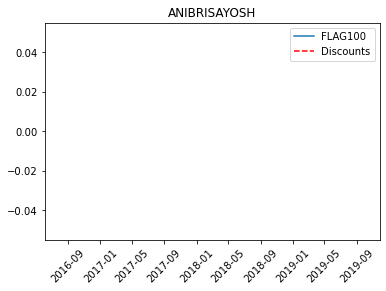

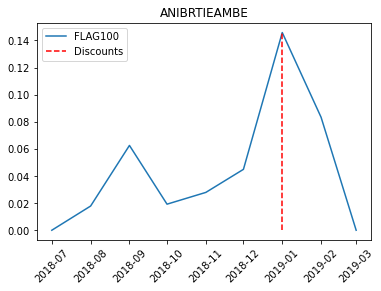

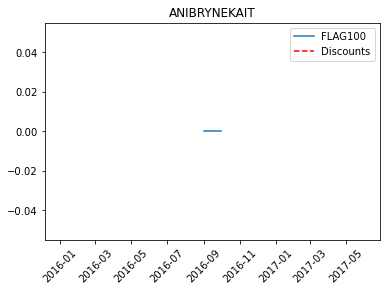

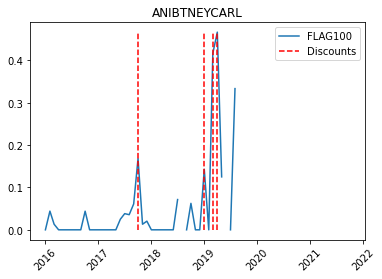

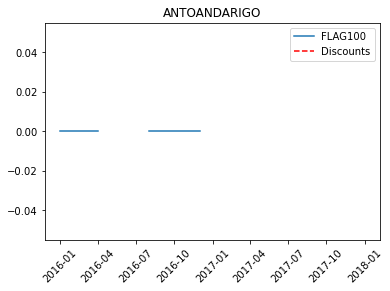

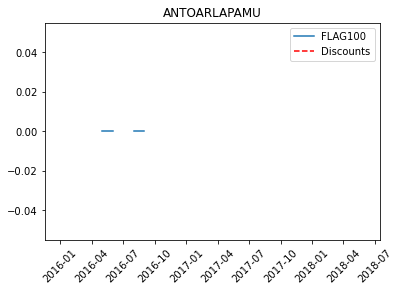

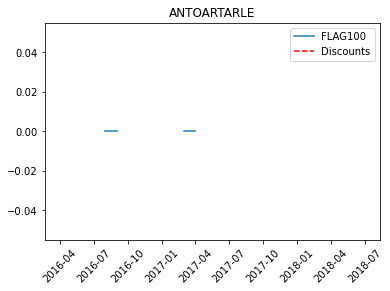

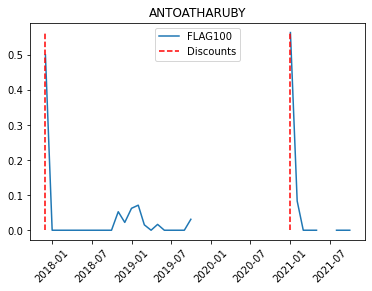

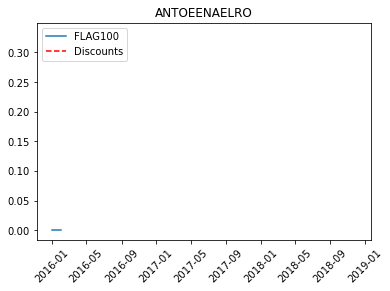

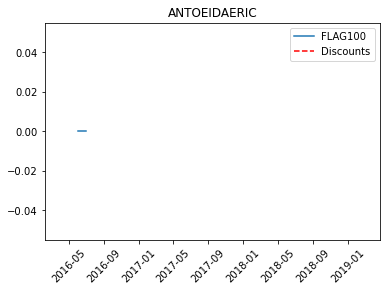

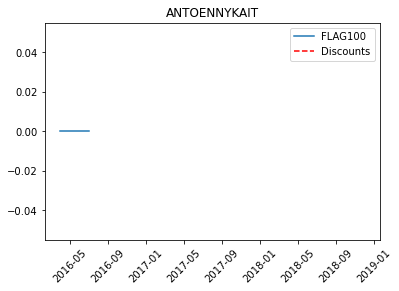

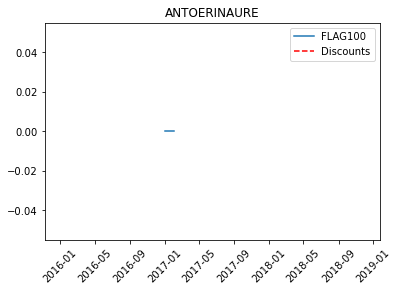

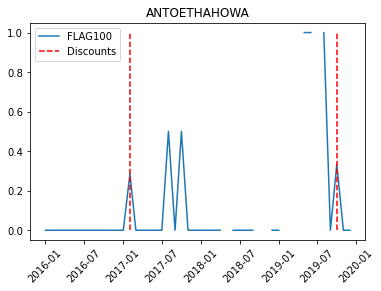

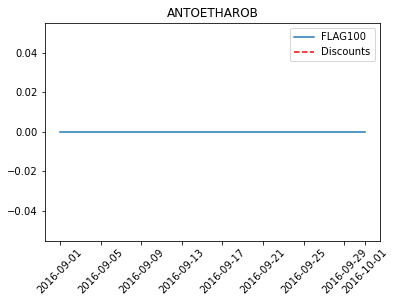

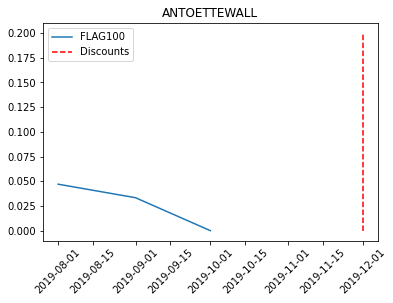

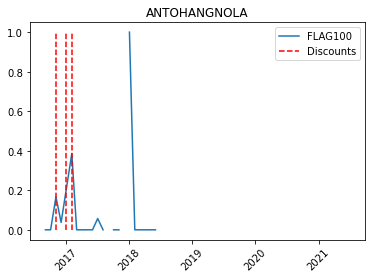

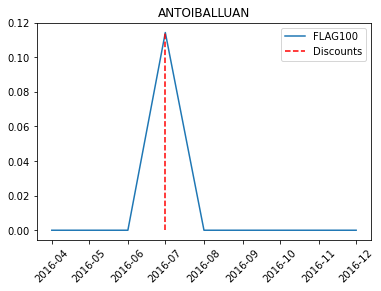

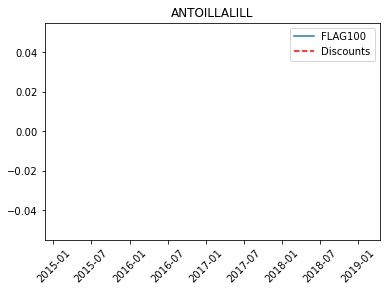

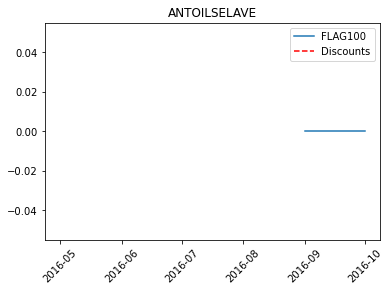

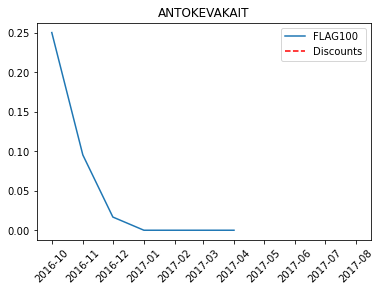

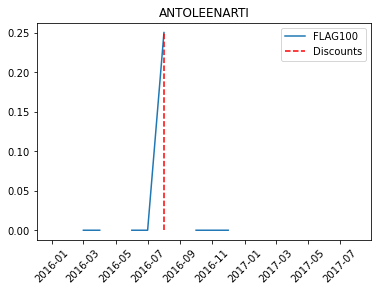

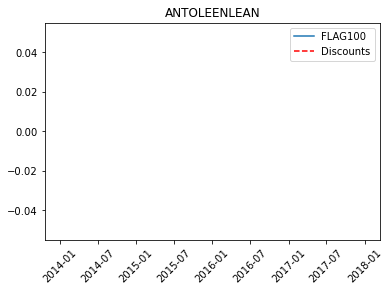

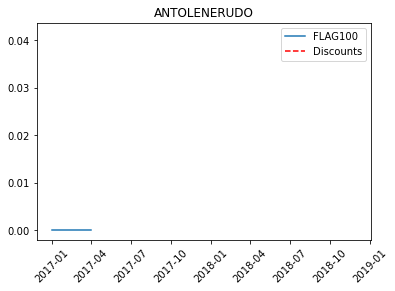

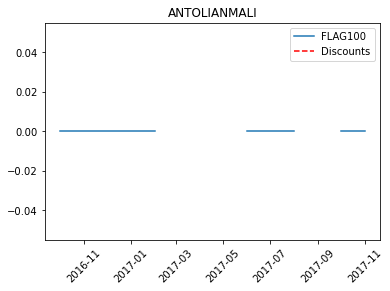

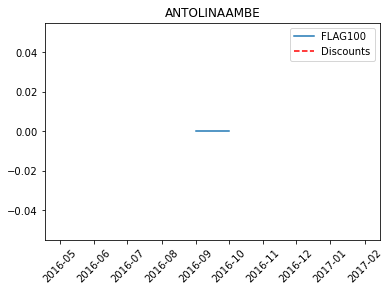

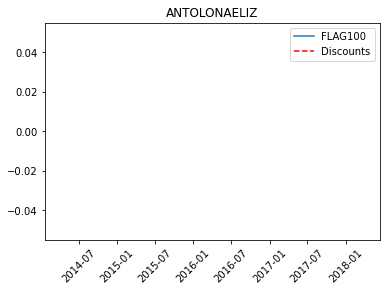

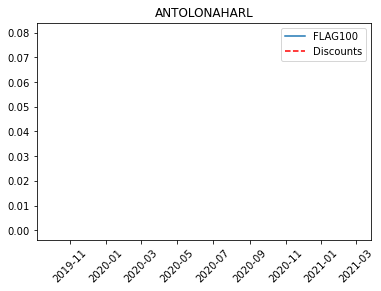

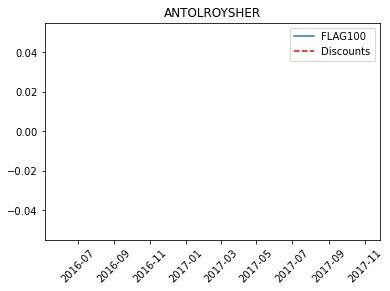

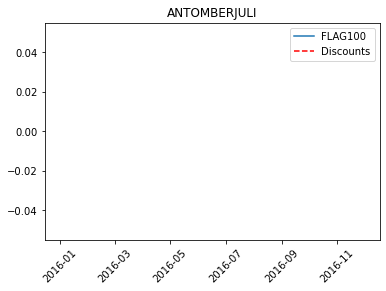

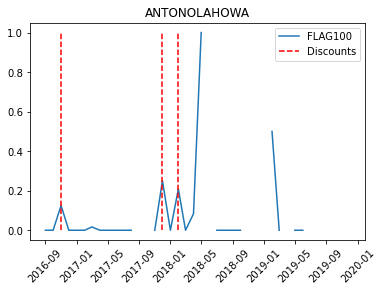

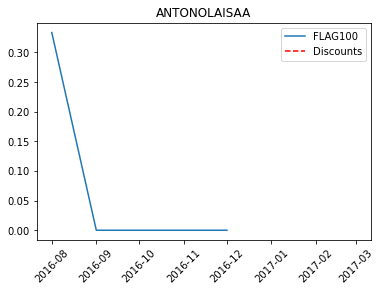

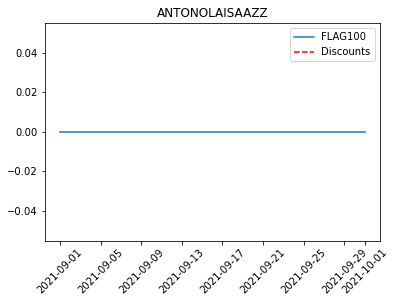

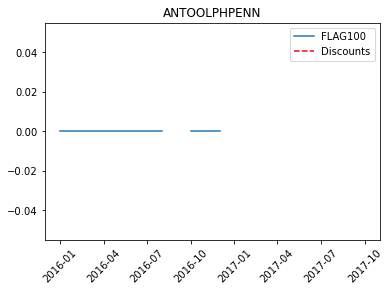

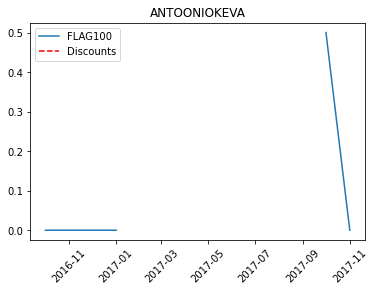

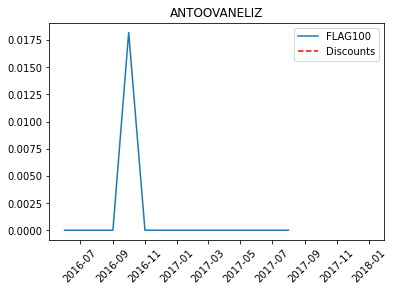

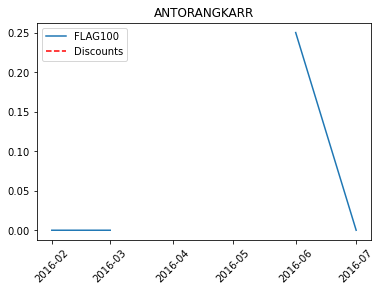

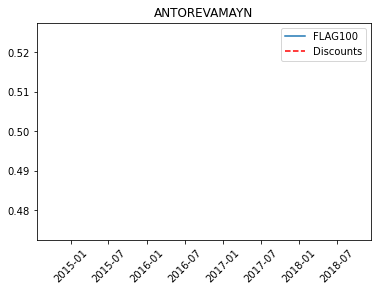

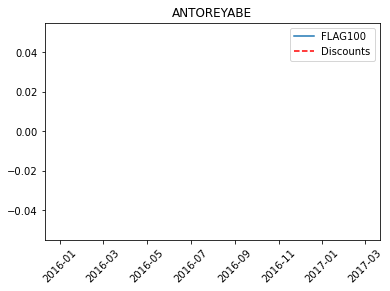

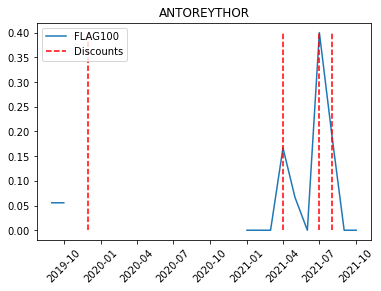

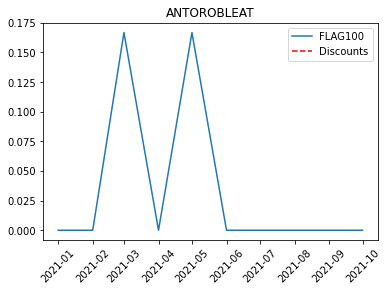

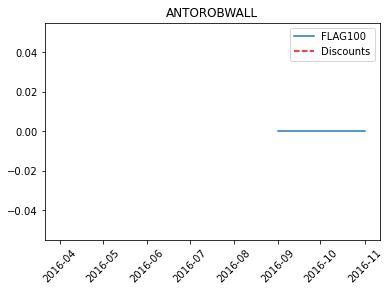

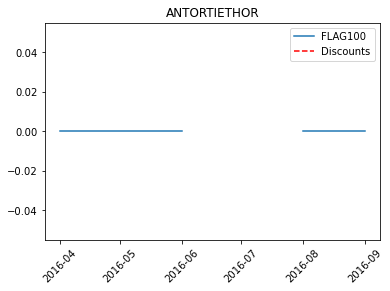

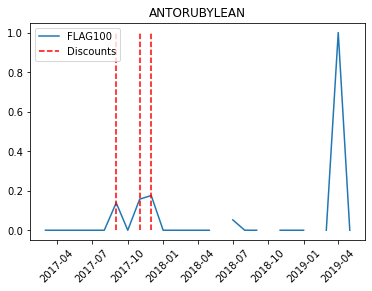

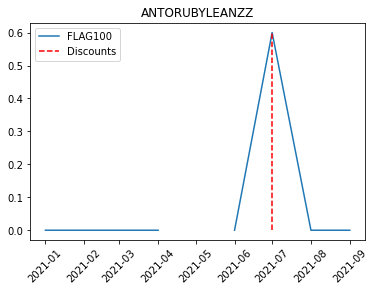

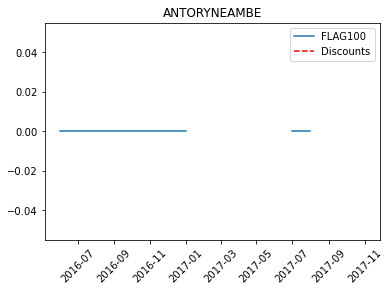

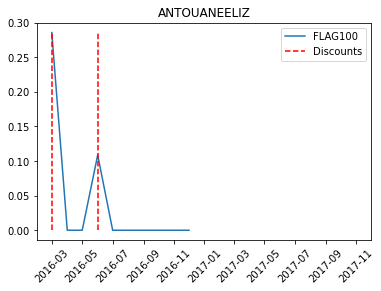

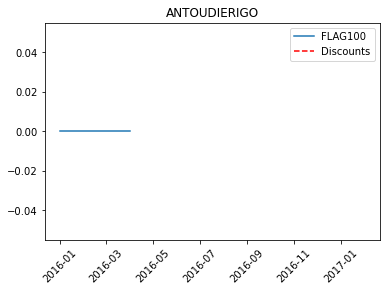

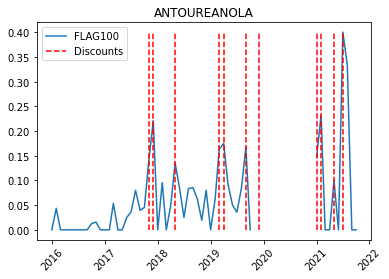

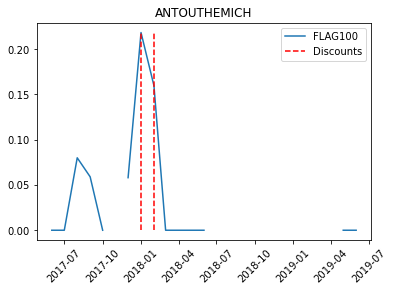

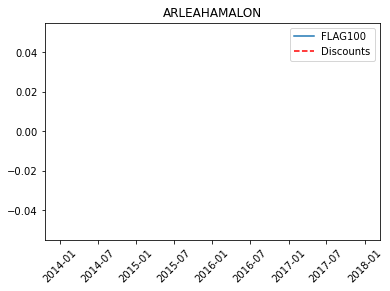

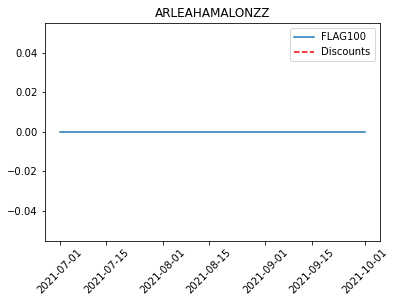

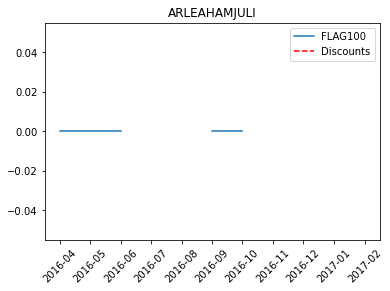

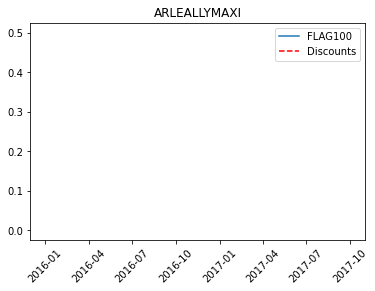

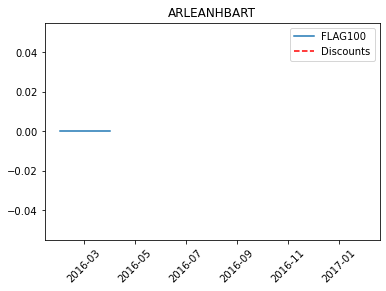

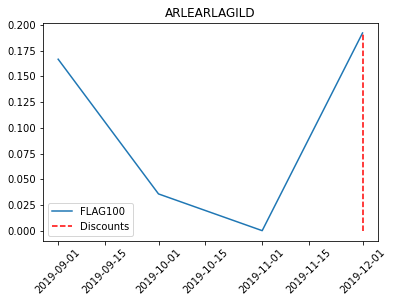

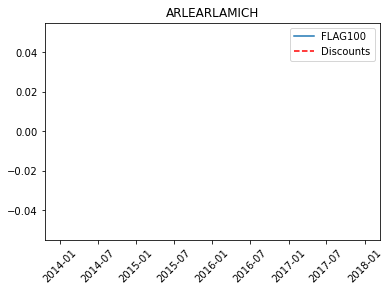

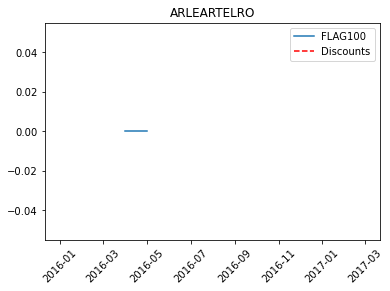

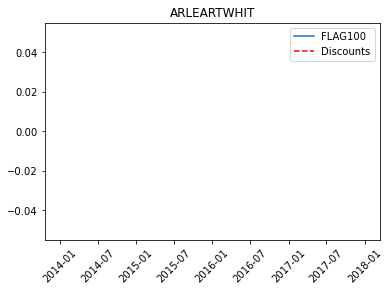

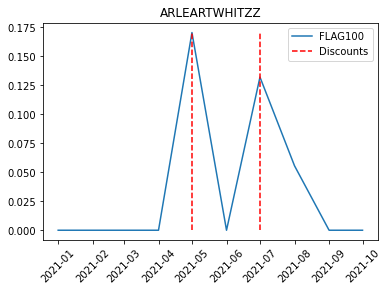

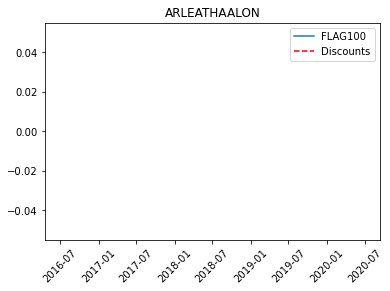

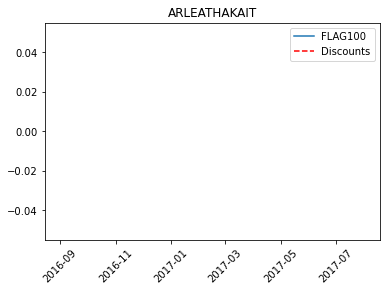

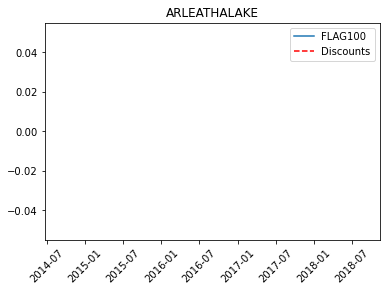

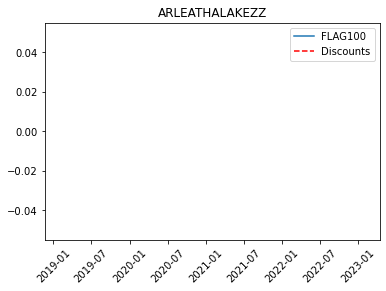

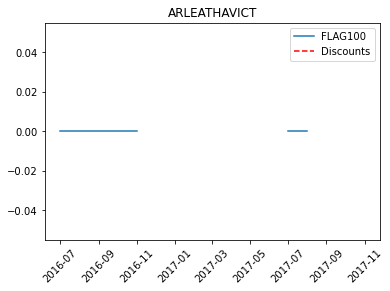

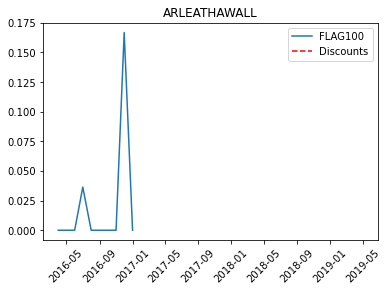

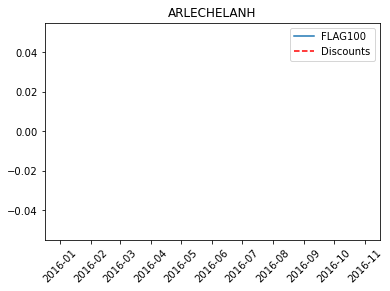

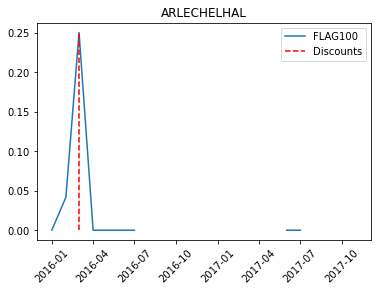

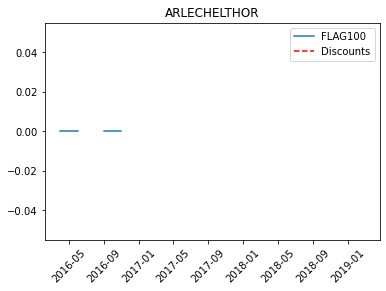

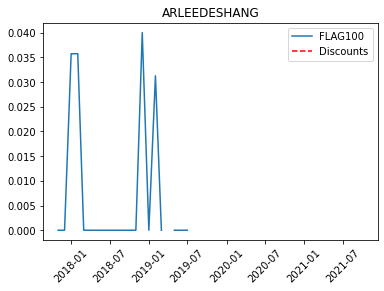

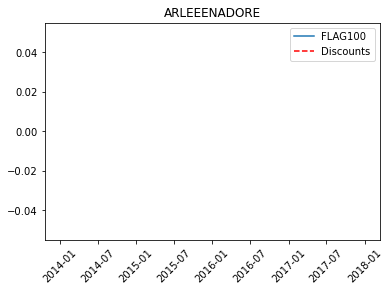

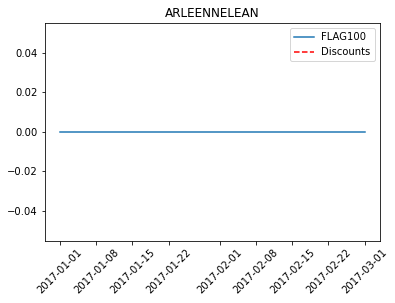

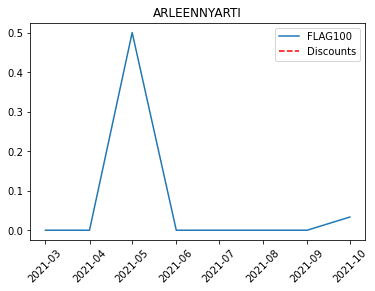

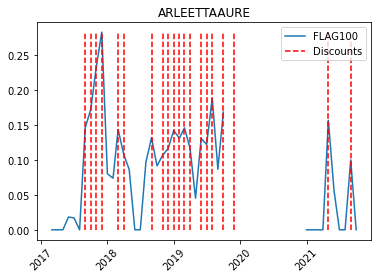

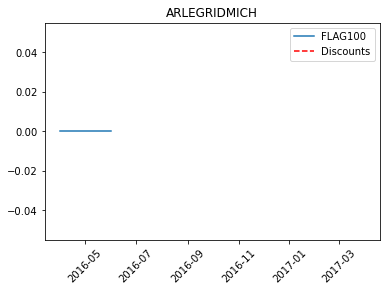

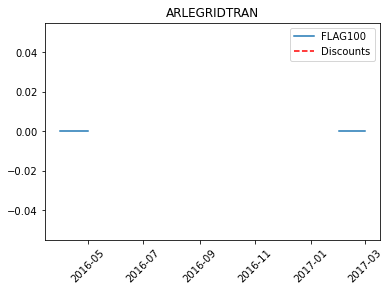

KeyboardInterrupt: 

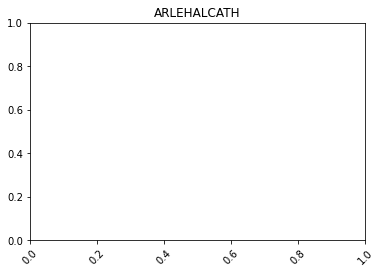

In [152]:
sku_groups = train.groupby(by = 'sku_name')
for sku_name, group in sku_groups:
    
    group = group.set_index(keys = group.ds)
    observations = group['FLAG100']
    ds = group.ds.values.astype('datetime64[M]')
    ts = make_ts(observations, ds, method = 'nofill')
    group = pd.concat([group,ts], axis=1)
    discounts = group[group.disc_month == 1].index
    
    plt.title(sku_name)
    plt.xticks(rotation=45)
    plt.plot(group.ds, group.FLAG100)
    plt.vlines(x = discounts, ymin = 0, ymax = max(group.FLAG100), color='r', ls='--', )
    plt.legend(['FLAG100', 'Discounts'])
    plt.show()

In [147]:
group[group.disc_month == 1].index

DatetimeIndex(['2016-11-01', '2017-11-01', '2017-12-01', '2018-01-01',
               '2019-01-01', '2019-12-01', '2021-01-01', '2021-08-01',
               '2021-10-01'],
              dtype='datetime64[ns]', freq=None)

In [156]:
values = {1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,
         9:0,10:0,11:0,12:0}
train_sku_groups = train.groupby(by = 'sku_name')
for sku_name, group in train_sku_groups:
    for index, row in group.iterrows():
        if row.disc_month == 1:
            values[row.month] += 1

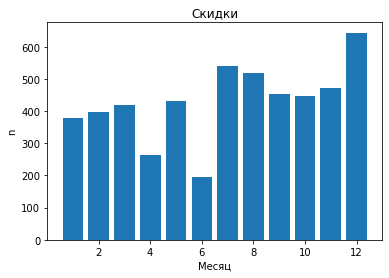

In [157]:
plt.title('Скидки')
plt.bar(x=np.arange(1,13), height = values.values())
plt.xlabel('Месяц')
plt.ylabel('n')
plt.show()

In [135]:
group[group.year>=2021].shape

(10, 20)